In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp, wilcoxon, ttest_rel, ttest_ind
from pymer4.models import Lmer
from tqdm import tqdm
import neural_helpers as nh
np.random.seed(1)
%load_ext autoreload
%autoreload 2

bids_dir = '/Volumes/shohamy-locker/chris/hybrid_mri_bids'
nibs_dir = f'{bids_dir}/derivatives/nibetaseries'

plt.rcParams['font.family'] = 'Palatino'


In [2]:
# all_patterns = nh.get_all_roi_patterns('hipp') # all_patterns[sub_num]['choice/fb'] = array(~300 trials x ~400 vox)
# all_patterns = nh.get_all_roi_patterns('loc')  # (~300 trials x ~700 voxels)
# all_patterns = nh.get_all_roi_patterns('striatum')  # (~300 trials x ~900 voxels)
# all_patterns = nh.get_all_roi_patterns('vmpfc')  # (~300 trials x ~700 voxels)

# hipp_patterns = nh.get_all_roi_patterns('hipp')
# vmpfc_patterns = nh.get_all_roi_patterns('vmpfc')

import pickle
with open(f"{bids_dir}/derivatives/nibetaseries/vmpfc_patterns.pkl", "rb") as f:
    vmpfc_patterns = pickle.load(f)

What's happening in this task?

During choice: 
- Querying memory for if you remember an associated value with each card
	- Reinstate the value
	- Decide based on the retrieved value
- Pre-existing deck preference
	- Based on last trial, or Q aggregate

During feedback
- Associating reward with deck
	- Reinstating deck color
	- Reinstating choice object to bind

## Models

In [ ]:
all_rows = []
for sub in range(1,32):
    beh_data  = nh.get_beh_data(sub)
    vmpfc_corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub, 'fb_to_choice')
    # hipp_corr_matrix = nh.get_corr_matrix(hipp_patterns, sub, 'fb_to_choice')

    encoding_indices, retrieval_indices = nh.get_encoding_retrieval_indices(sub) # all encoding and retrieval trials
    for i,ret_idx in enumerate(retrieval_indices):
        for enc_idx,row in beh_data.iterrows():
            if row.OldT==0: # compare each old/new (retrieval) trial to each new/new trial (encoding trials + others) t
                all_rows.append({
                    'corr_z_vmpfc': np.arctanh(vmpfc_corr_matrix[ret_idx,enc_idx]),
                    # 'corr_z_hipp': np.arctanh(hipp_corr_matrix[ret_idx,enc_idx]),
                    'is_encoding_match': int(enc_idx == encoding_indices[i]),
                    'is_reward_match': int(beh_data.ObjPP.iloc[ret_idx] == beh_data.Outcome.iloc[enc_idx]),
                    'is_luck_match': int(beh_data.LuckyDeck.iloc[ret_idx] == beh_data.LuckyDeck.iloc[enc_idx]),
                    'trials_in_between': abs(beh_data.Trial.iloc[ret_idx] - beh_data.Trial.iloc[enc_idx]),
                    'Sub': sub,
                    'retrieval_trial': ret_idx,
                    'encoding_trial': enc_idx
                })
df_long = pd.DataFrame(all_rows)


sns.catplot(y='corr_z_vmpfc', x='is_encoding_match', hue='is_luck_match', col='is_reward_match', kind='point',
            data=df_long.groupby(['Sub', 'is_encoding_match', 'is_reward_match', 'is_luck_match'], as_index=False).agg({'corr_z_vmpfc': 'mean'})
)
plt.suptitle('vmpfc')
plt.show()

sns.catplot(y='corr_z_hipp', x='is_encoding_match', hue='is_luck_match', col='is_reward_match', kind='point',
            data=df_long.groupby(['Sub', 'is_encoding_match', 'is_reward_match', 'is_luck_match'], as_index=False).agg({'corr_z_hipp': 'mean'})
)
plt.suptitle('hippocampus')
plt.show()

In [6]:
### VMPFC
model = Lmer(
    "corr_z_vmpfc ~  is_encoding_match + is_reward_match + is_luck_match + "
    "( 1 + is_encoding_match + is_reward_match + is_luck_match || Sub) + (1 | trials_in_between)",
    data=df_long
)
model.fit(summarize=False)
print(model.summary())

# #### HIPP
# model = Lmer(
#     "corr_z_hipp ~  is_encoding_match + is_reward_match + is_luck_match + "
#     "( 1 + is_encoding_match + is_reward_match + is_luck_match | Sub) + (1 | trials_in_between)",
#     data=df_long
# )
# model.fit(summarize=False)
# print(model.summary())

Model failed to converge with max|grad| = 0.0931217 (tol = 0.002, component 1) 



/Users/chrisiyer/miniconda3/envs/hbi/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: corr_z_vmpfc~is_encoding_match+is_reward_match+is_luck_match+(1+is_encoding_match+is_reward_match+is_luck_match||Sub)+(1|trials_in_between)

Family: gaussian	 Inference: parametric

Number of observations: 644029	 Groups: {'trials_in_between': 299.0, 'Sub': 31.0}

Log-likelihood: 77737.044 	 AIC: -155454.088

Random effects:

                                Name    Var    Std
trials_in_between        (Intercept)  0.000  0.009
Sub                    is_luck_match  0.000  0.000
Sub.1                is_reward_match  0.000  0.003
Sub.2              is_encoding_match  0.000  0.006
Sub.3                    (Intercept)  0.000  0.001
Residual                              0.046  0.214

No random effect correlations specified

Fixed effects:

                   Estimate  2.5_ci  97.5_ci     SE         DF  T-stat  P-val  \
(Intercept)          -0.001  -0.002    0.001  0.001    350.363  -1.176  0.240   
is_encoding_match     0.009   0.002    0.01

In [ ]:
# now model choice: do optimal episodic choices predict higher pattern correlation?
# we're pretty sure they dont, but it's worth a shot

opt_obj,opt_q,ep_lik,inc_lik = [],[],[],[]
for sub in range(1,32):
    beh_data  = nh.get_beh_data(sub)
    encoding_indices, retrieval_indices = nh.get_encoding_retrieval_indices(sub) # all encoding and retrieval trials
    for i,ret_idx in enumerate(retrieval_indices):
        opt_obj.append(beh_data.OptObj.iloc[ret_idx])
        opt_q.append(int(beh_data.Q_diff.iloc[ret_idx] > 0))
        ep_lik.append(beh_data.Ep_lik.iloc[ret_idx])
        inc_lik.append(beh_data.Inc_lik.iloc[ret_idx])

df_opt = df_long[df_long.is_encoding_match==1]
df_opt['optimal_episodic'] = opt_obj
df_opt['optimal_Q'] = opt_q
df_opt['ep_lik'] = ep_lik
df_opt['inc_lik'] = inc_lik

# model = Lmer(
#     "corr_z_vmpfc ~  optimal_episodic + optimal_Q + is_luck_match + (1 | Sub) + (1  | trials_in_between)",
#     data=df_opt
# )
# model.fit(summarize=False)
# print(model.summary())

# model = Lmer(
#     "corr_z_hipp ~  optimal_episodic + optimal_Q + is_luck_match + (1 | Sub) + (1  | trials_in_between)",
#     data=df_opt
# )
# model.fit(summarize=False)
# print(model.summary())

model = Lmer(
    "corr_z_vmpfc ~  ep_lik + inc_lik + ( 1 | Sub) + (1  | trials_in_between)",
    data=df_opt
)
model.fit(summarize=False)
print(model.summary())

# Pattern analyses

### 1. Is correlation higher for encoding-retrieval pairs than unrelated pairs?

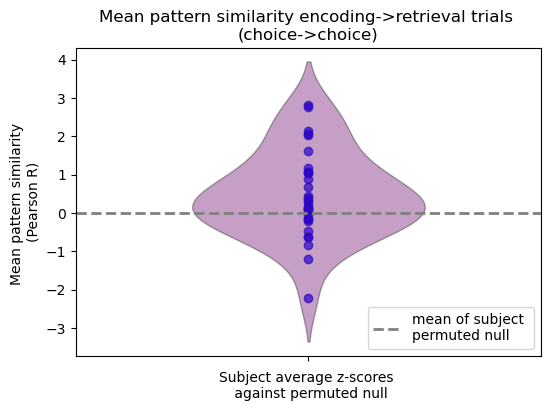

T-test result: p = 0.025411402268449713
Wilcoxon result: p = 0.033809719607234


In [ ]:
# for each subject
# calculate average encoding->retrieval similarity
# shuffle encoding and retrieval pairs, get similarity for null
# get the z-score of the data relative to empirical null
# run t-test of subject z-scores against 0
# plot violin plot of subject z-scores

sub_z_scores= []
n_iter = 1000
for sub_num in range(1,32):
    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'choice')
    encoding_indices, retrieval_indices, values = nh.get_encoding_retrieval_indices(sub_num, return_values=True)
    mean_corr = np.mean(corr_matrix[retrieval_indices, encoding_indices])
    perm_corrs = []
    for _ in range(n_iter):
        permuted_retrieval = nh.permute_retrieval_indices(encoding_indices, retrieval_indices, values_to_match = values)
        perm_corrs.append( np.mean(corr_matrix[permuted_retrieval, encoding_indices]) )
    z = (mean_corr - np.mean(perm_corrs)) / np.std(perm_corrs, ddof=1)
    sub_z_scores.append(z)

nh.simple_violin(sub_z_scores, 
                 xlim=(-0.8,0.8),
                 xlabel='Subject average z-scores \n against permuted null', 
                 ylabel='Mean pattern similarity \n(Pearson R)',
                 title='Mean pattern similarity encoding->retrieval trials \n(choice->choice)',
                 chancelabel='mean of subject \npermuted null', legend=True)

print('T-test result: p =', ttest_1samp(sub_z_scores,0).pvalue)
print('Wilcoxon result: p =', wilcoxon(sub_z_scores).pvalue)

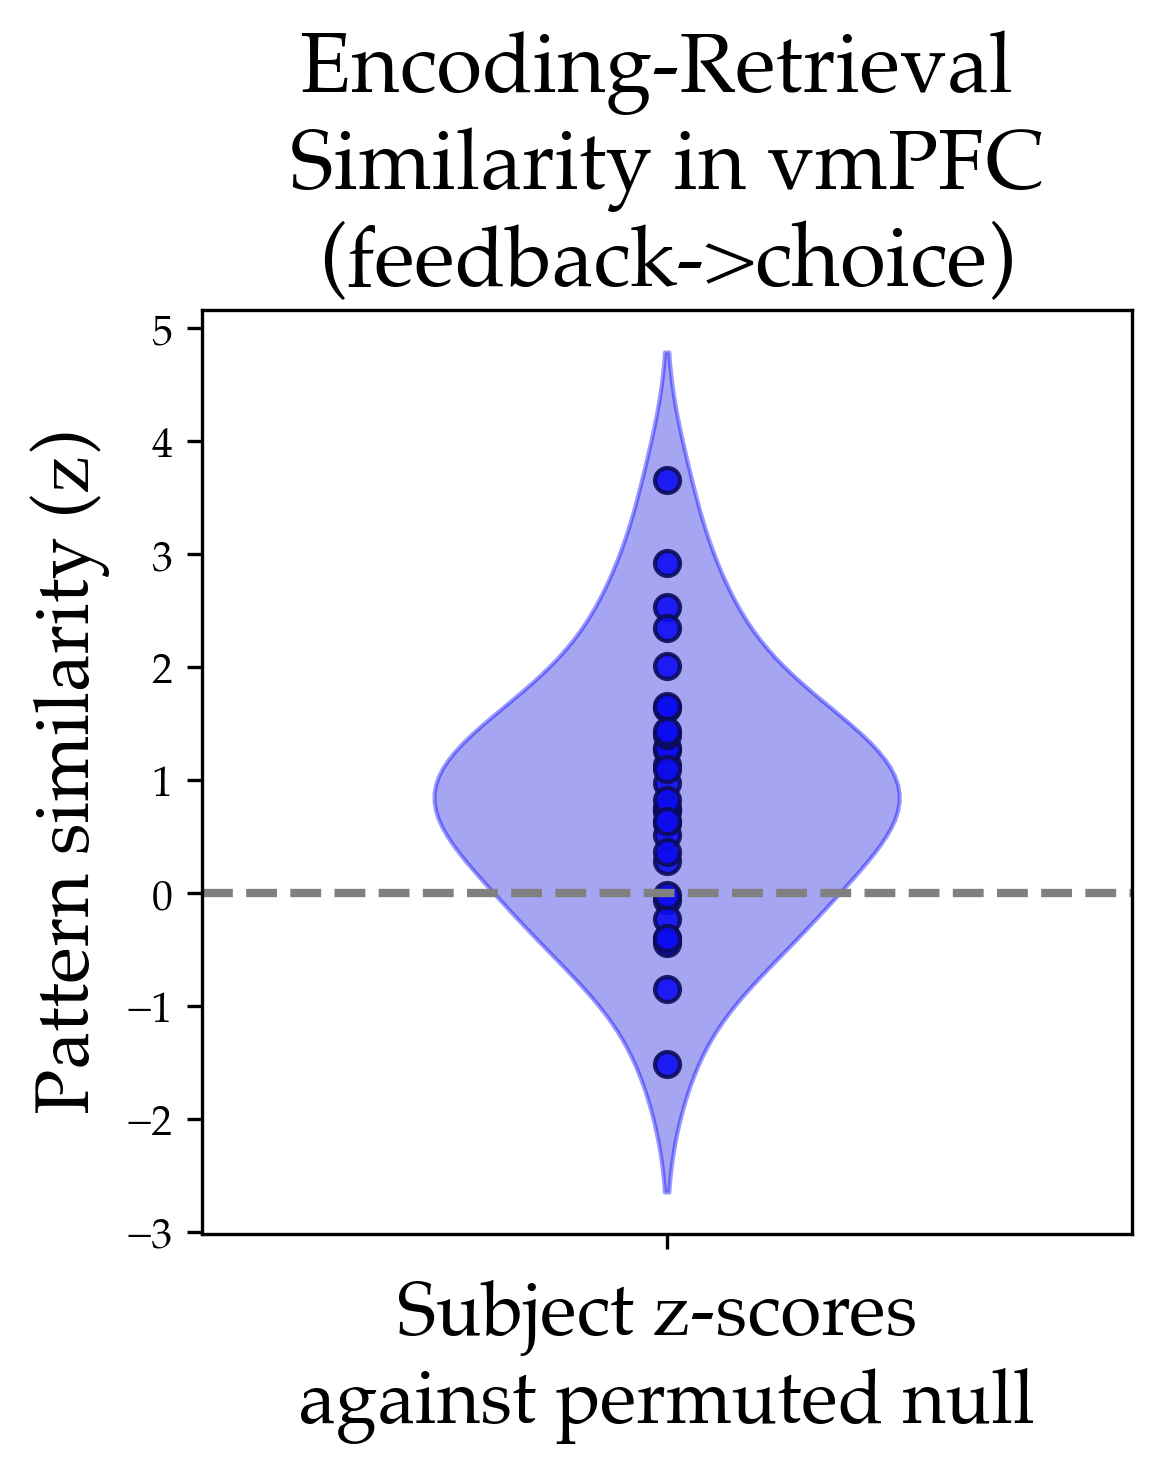

T-test result: p = 0.0001618167958709119
Wilcoxon result: p = 0.000177089124917984


TtestResult(statistic=4.310137222919052, pvalue=0.0001618167958709119, df=30)

In [3]:
# feedback -> choice

sub_z_scores= []
n_iter = 1000
for i,sub_num in enumerate(range(1,32)):
    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'fb_to_choice')
    encoding_indices, retrieval_indices, values = nh.get_encoding_retrieval_indices(sub_num, return_values=True)
    mean_corr = np.mean(corr_matrix[retrieval_indices, encoding_indices])
    perm_corrs = []
    for _ in range(n_iter):
        permuted_retrieval = nh.permute_retrieval_indices(encoding_indices, retrieval_indices, values_to_match = values)
        perm_corrs.append( np.mean(corr_matrix[permuted_retrieval, encoding_indices]) )
    
    z = (mean_corr - np.mean(perm_corrs)) / np.std(perm_corrs, ddof=1)
    sub_z_scores.append(z)


nh.simple_violin(sub_z_scores, dpi=300,figsize=(4,4),
                 xlim=(-0.8,0.8),
                 xlabel='Subject z-scores \nagainst permuted null', 
                 ylabel='Pattern similarity (z)',
                 title='Encoding-Retrieval \nSimilarity in vmPFC\n(feedback->choice)',
                 chancelabel='mean of subject null')
                 

print('T-test result: p =', ttest_1samp(sub_z_scores,0).pvalue)
print('Wilcoxon result: p =', wilcoxon(sub_z_scores).pvalue)
ttest_1samp(sub_z_scores,0)

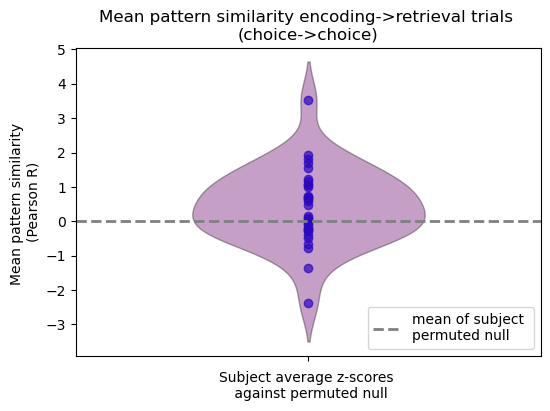

T-test result: p = 0.043051655557276455
Wilcoxon result: p = 0.04345365799963474


In [ ]:
# hippocampus
sub_z_scores= []
n_iter = 1000
for sub_num in range(1,32):
    corr_matrix = nh.get_corr_matrix(hipp_patterns, sub_num, 'fb_to_choice')
    encoding_indices, retrieval_indices, values = nh.get_encoding_retrieval_indices(sub_num, return_values=True)
    mean_corr = np.mean(corr_matrix[retrieval_indices, encoding_indices])
    perm_corrs = []
    for _ in range(n_iter):
        permuted_retrieval = nh.permute_retrieval_indices(encoding_indices, retrieval_indices, values_to_match = values)
        perm_corrs.append( np.mean(corr_matrix[permuted_retrieval, encoding_indices]) )
    z = (mean_corr - np.mean(perm_corrs)) / np.std(perm_corrs, ddof=1)
    sub_z_scores.append(z)

nh.simple_violin(sub_z_scores, 
                 xlim=(-0.8,0.8),
                 xlabel='Subject average z-scores \n against permuted null', 
                 ylabel='Mean pattern similarity \n(Pearson R)',
                 title='Mean pattern similarity encoding->retrieval trials \n(choice->choice)',
                 chancelabel='mean of subject \npermuted null', legend=True)

print('T-test result: p =', ttest_1samp(sub_z_scores,0).pvalue)
print('Wilcoxon result: p =', wilcoxon(sub_z_scores).pvalue)

### 2. Does ERS predict memory choice? (only unlucky deck choices)

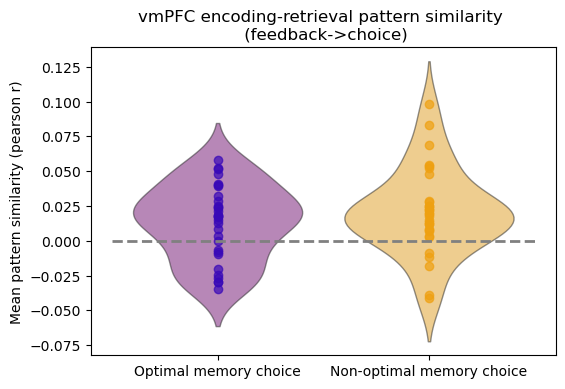

Two sample t-test result: p = 0.2698506180844316


In [ ]:
ps_opt = []
ps_nonopt = []

for sub_num in range(1,32):

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'fb_to_choice') 

    encoding_indices, retrieval_indices = nh.get_encoding_retrieval_indices(sub_num)

    encoding_opt = [e for i,e in enumerate(encoding_indices) if beh_data.OptObj.iloc[retrieval_indices[i]] == 1]
    encoding_nonopt = [e for e in encoding_indices if e not in encoding_opt]
    retrieval_opt = [r for r in retrieval_indices if beh_data.OptObj.iloc[r] == 1]
    retrieval_nonopt = [r for r in retrieval_indices if r not in retrieval_opt]

    ps_opt.append( np.mean( corr_matrix[retrieval_opt, encoding_opt] ) )
    ps_nonopt.append( np.mean( corr_matrix[retrieval_nonopt, encoding_nonopt] ) ) # and beh_data.Q_diff.iloc[i] < 0


nh.simple_violin(ps_opt, ps_nonopt,
              title = 'vmPFC encoding-retrieval pattern similarity \n (feedback->choice)', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Optimal memory choice', x2_label = 'Non-optimal memory choice',
              chancelabel='')
print('Two sample t-test result: p =', ttest_rel(ps_opt, ps_nonopt).pvalue)

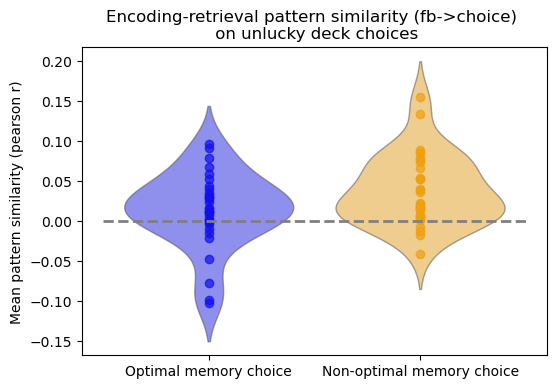

Two sample t-test result: p = 0.04572559920048353


In [ ]:
ps_opt = []
ps_nonopt = []

for sub_num in range(1,32):

    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'fb_to_choice') 
    beh_data = nh.get_beh_data(sub_num)
    
    encoding_indices, retrieval_indices = nh.get_encoding_retrieval_indices(sub_num, only_unlucky=True)

    encoding_opt = [e for i,e in enumerate(encoding_indices) if beh_data.OptObj.iloc[retrieval_indices[i]] == 1]
    encoding_nonopt = [e for e in encoding_indices if e not in encoding_opt]
    retrieval_opt = [r for r in retrieval_indices if beh_data.OptObj.iloc[r] == 1]
    retrieval_nonopt = [r for r in retrieval_indices if r not in retrieval_opt]

    ps_opt.append( np.mean( corr_matrix[retrieval_opt, encoding_opt] ) )
    ps_nonopt.append( np.mean( corr_matrix[retrieval_nonopt, encoding_nonopt] ) ) # and beh_data.Q_diff.iloc[i] < 0


nh.simple_violin(ps_opt, ps_nonopt,
              title = 'Encoding-retrieval pattern similarity (fb->choice) \n on unlucky deck choices', 
              ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Optimal memory choice', x2_label = 'Non-optimal memory choice',
              chancelabel='')
print('Two sample t-test result: p =', ttest_rel(ps_opt, ps_nonopt).pvalue)

### 3. Similarity kernel of retrieval trial to those around encoding trial. Does this similarity predict old/new trial performance? old vs. new choices, optimal vs. nonoptimal

In [ ]:
# what could be driving this lingering (and asymmetric) effect ?
# separate trials that match value and trials with mismatched value

enc_to_ret,ret_to_enc = [],[] 

for sub_num in range(1,32):
    sub_enc_to_ret,sub_ret_to_enc = [],[] 

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'fb_to_choice')
    encoding_indices,retrieval_indices = nh.get_encoding_retrieval_indices(sub_num)

    for enc_idx,ret_idx in zip(encoding_indices, retrieval_indices):

        enc_window_vals = np.repeat(np.nan, 11) # 5 trials before encoding and 5 trials after
        enc_window_vals_diffvalue = np.repeat(np.nan, 11)
        for i,step in enumerate(range(-5,6)):
            enc_idx_to_check = enc_idx + step
            # make sure it's a valid trial and control to be not crossing a reversal
            if 0 < enc_idx_to_check < len(beh_data) and beh_data.LuckyDeck.iloc[enc_idx_to_check] == beh_data.LuckyDeck.iloc[enc_idx]:
                # if beh_data.Outcome.iloc[enc_idx_to_check] == beh_data.Outcome.iloc[ret_idx]:
                enc_window_vals[i] = corr_matrix[ret_idx, enc_idx_to_check]
        sub_enc_to_ret.append(enc_window_vals)

        ret_window_vals = np.repeat(np.nan, 11) 
        ret_window_vals_diffvalue = np.repeat(np.nan, 11) 
        for i,step in enumerate(range(-5,6)): 
            ret_idx_to_check = ret_idx + step
            if 0 < ret_idx_to_check < len(beh_data) and beh_data.LuckyDeck.iloc[ret_idx_to_check] == beh_data.LuckyDeck.iloc[ret_idx]: 
                # if beh_data.ObjPP.iloc[ret_idx_to_check] == beh_data.ObjPP.iloc[ret_idx]:
                ret_window_vals[i] = corr_matrix[ret_idx_to_check, enc_idx]
        sub_ret_to_enc.append(ret_window_vals)

    # get subject mean at each index and add to the group array 
    enc_to_ret.append(np.nanmean(sub_enc_to_ret, axis=0))
    ret_to_enc.append(np.nanmean(sub_ret_to_enc, axis=0))
    

nh.plot_enc_kernel_double(ret_to_enc,enc_to_ret, figtitle="Encoding-Retrieval Similarity to Nearby Trials \n(within reversal)",
                          xlabels=["Distance from true encoding trial \n(feedback)", "Distance from true retrieval trial \n(choice)"],
                          titles=["Around encoding trial", "Around retrieval trial"])

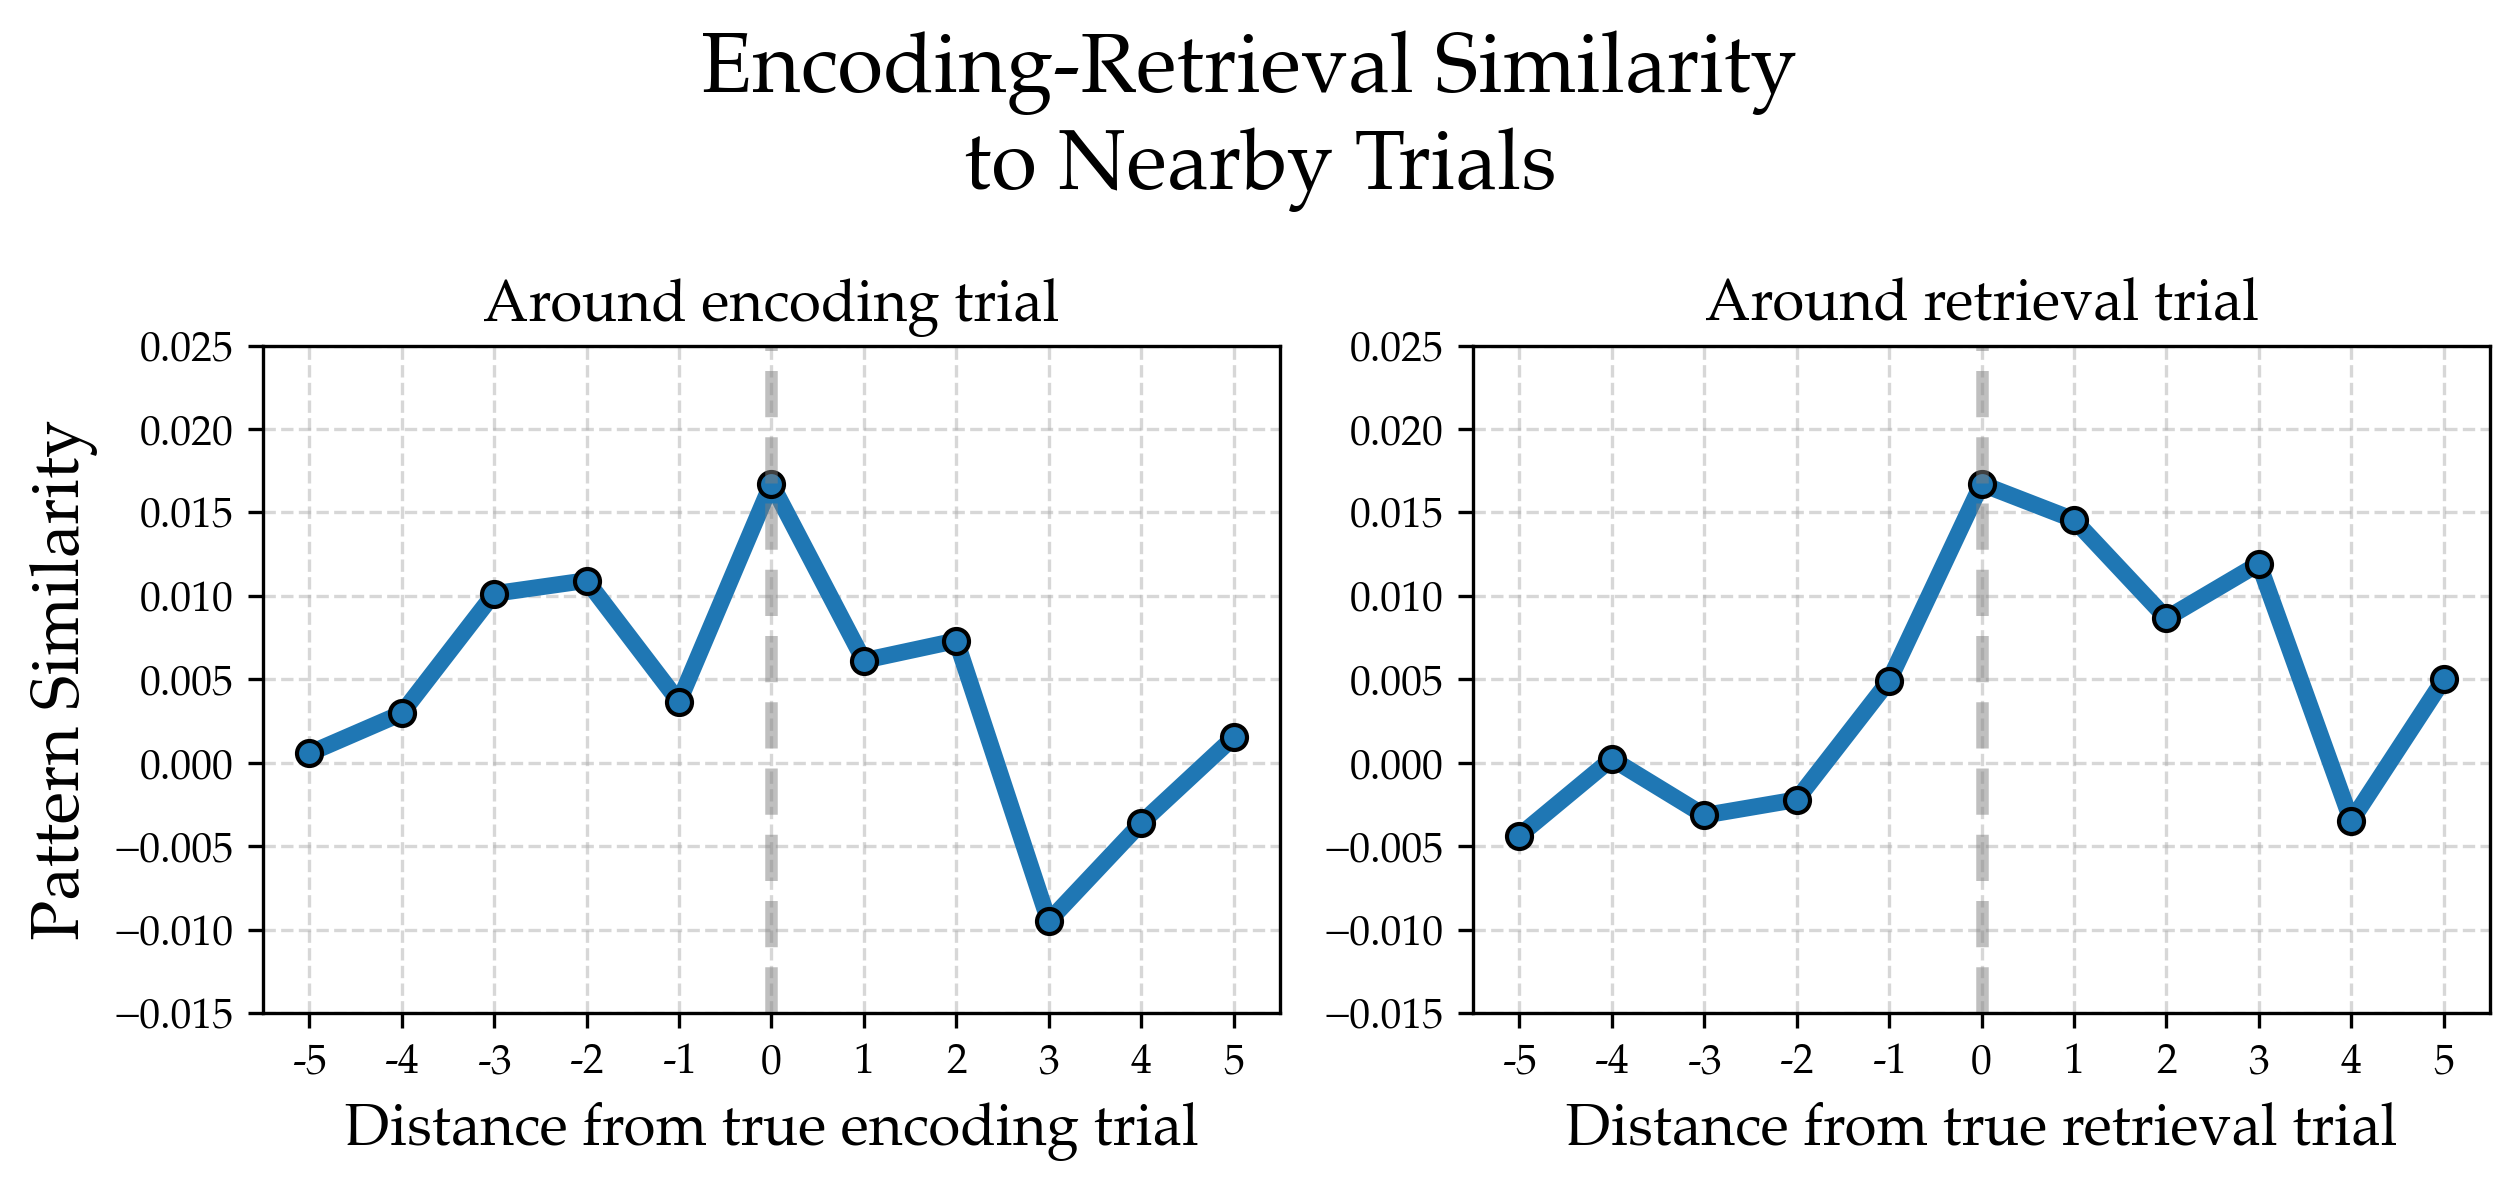

In [ ]:
nh.plot_enc_kernel_double(ret_to_enc,enc_to_ret, figtitle="Encoding-Retrieval Similarity \nto Nearby Trials",
                          xlabels=["Distance from true encoding trial", "Distance from true retrieval trial"],
                          titles=["Around encoding trial", "Around retrieval trial"]) # ,vertical=True

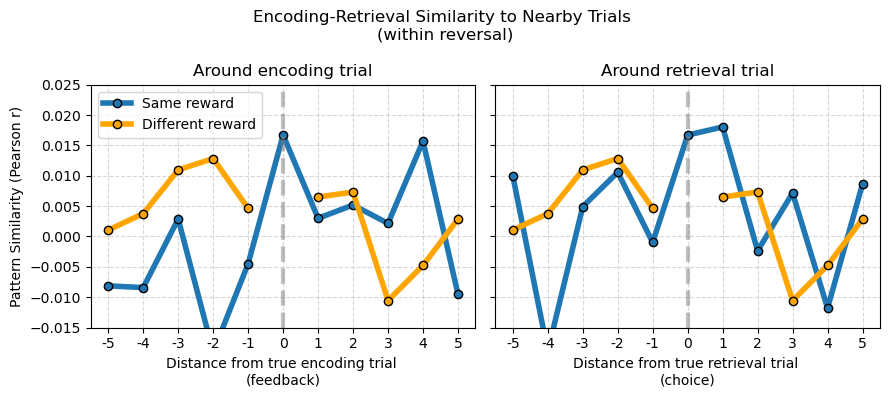

In [190]:
# what could be driving this lingering (and asymmetric) effect ?
# separate trials that match value and trials with mismatched value

enc_to_ret_samevalue,ret_to_enc_samevalue = [],[] 
enc_to_ret_diffvalue,ret_to_enc_diffvalue = [],[] 

for sub_num in range(1,32):
    sub_enc_to_ret_samevalue,sub_ret_to_enc_samevalue = [],[] 
    sub_enc_to_ret_diffvalue,sub_ret_to_enc_diffvalue = [],[] 

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'fb_to_choice')
    encoding_indices,retrieval_indices = nh.get_encoding_retrieval_indices(sub_num)

    for enc_idx,ret_idx in zip(encoding_indices, retrieval_indices):

        enc_window_vals_samevalue = np.repeat(np.nan, 11) # 5 trials before encoding and 5 trials after
        enc_window_vals_diffvalue = np.repeat(np.nan, 11)
        for i,step in enumerate(range(-5,6)):
            enc_idx_to_check = enc_idx + step
            # make sure it's a valid trial and control to be not crossing a reversal
            if 0 < enc_idx_to_check < len(beh_data) and beh_data.LuckyDeck.iloc[enc_idx_to_check] == beh_data.LuckyDeck.iloc[enc_idx]:
                if beh_data.Outcome.iloc[enc_idx_to_check] == beh_data.Outcome.iloc[enc_idx]:
                    # same value
                    enc_window_vals_samevalue[i] = corr_matrix[ret_idx, enc_idx_to_check]
                elif step!=0:
                    enc_window_vals_diffvalue[i] = corr_matrix[ret_idx, enc_idx_to_check]
        sub_enc_to_ret_samevalue.append(enc_window_vals_samevalue)
        sub_enc_to_ret_diffvalue.append(enc_window_vals_diffvalue)

        ret_window_vals_samevalue = np.repeat(np.nan, 11) 
        ret_window_vals_diffvalue = np.repeat(np.nan, 11) 
        for i,step in enumerate(range(-5,6)): 
            ret_idx_to_check = ret_idx + step
            # if beh_data.ObjPP.iloc[ret_idx_to_check] == beh_data.ObjPP.iloc[ret_idx]:
            if 0 < ret_idx_to_check < len(beh_data) and beh_data.LuckyDeck.iloc[ret_idx_to_check] == beh_data.LuckyDeck.iloc[ret_idx]: 
                if beh_data.ObjPP.iloc[ret_idx_to_check] == beh_data.ObjPP.iloc[ret_idx]:
                    # same value
                    ret_window_vals_samevalue[i] = corr_matrix[ret_idx_to_check, enc_idx]
                elif step!=0:
                    ret_window_vals_diffvalue[i] = corr_matrix[ret_idx_to_check, enc_idx]
        sub_ret_to_enc_samevalue.append(ret_window_vals_samevalue)
        sub_ret_to_enc_diffvalue.append(ret_window_vals_diffvalue)

    # get subject mean at each index and add to the group array 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        enc_to_ret_samevalue.append(np.nanmean(sub_enc_to_ret_samevalue, axis=0))
        ret_to_enc_samevalue.append(np.nanmean(sub_ret_to_enc_samevalue, axis=0))
        enc_to_ret_diffvalue.append(np.nanmean(sub_enc_to_ret_diffvalue, axis=0))
        ret_to_enc_diffvalue.append(np.nanmean(sub_ret_to_enc_diffvalue, axis=0))


nh.plot_enc_kernel_double(ret_to_enc_samevalue,enc_to_ret_samevalue, ret_to_enc_diffvalue,ret_to_enc_diffvalue,
                          labels=['Same reward', 'Different reward'],
                          figtitle="Encoding-Retrieval Similarity to Nearby Trials \n(within reversal)",
                          xlabels=["Distance from true encoding trial \n(feedback)", "Distance from true retrieval trial \n(choice)"],
                          titles=["Around encoding trial", "Around retrieval trial"])

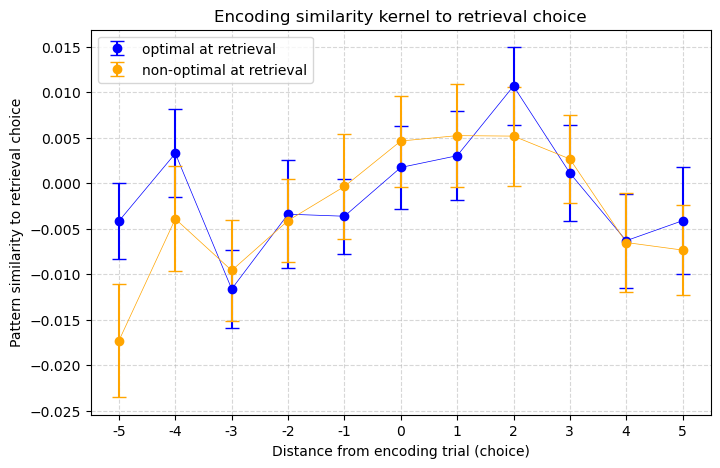

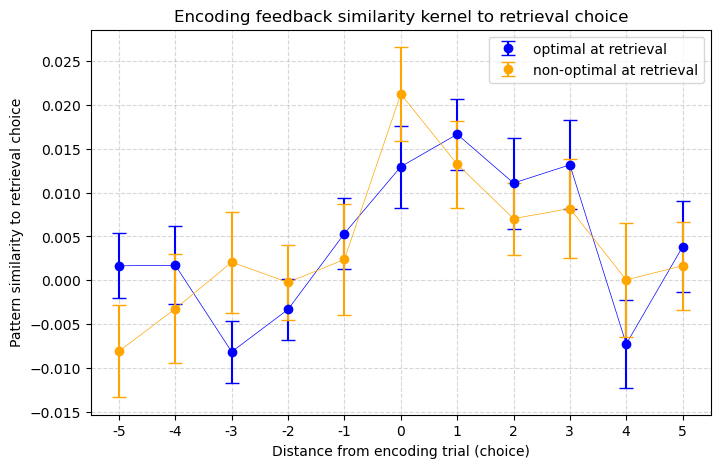

In [ ]:
# SEPARATE OPTIMAL & NONOPTIMAL
# for each old trial, get the pattern similarity to the encoding trial +- 5 trials
# separate optimal and non-optimal memory performance

enc_choice_kernel_ps_opt = [] 
enc_choice_kernel_ps_nonopt = [] 
enc_fb_kernel_ps_opt = [] 
enc_fb_kernel_ps_nonopt = [] 

for sub_num in range(1,32):
    subject_enc_choice_kernel_ps_opt = []
    subject_enc_choice_kernel_ps_nonopt = []
    subject_enc_fb_kernel_ps_opt = []
    subject_enc_fb_kernel_ps_nonopt = []

    beh_data = nh.get_beh_data(sub_num)
    choice_corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'choice')
    fb_corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1:
            # get the index of the encoding trial (not the same as trial number in beh_data)
            if row.encTrialNum in beh_data.Trial.to_numpy(): # some invalid trials not here
                idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
                # get the 5 preceding and following trials
                ps_choice_window = np.repeat(np.nan, 11)
                ps_fb_window = np.repeat(np.nan, 11)
                # extract correlations for this window of trials
                for j,step in enumerate(range(-5,6)):
                    idx_to_check = idx_of_enc_trial + step
                    if idx_to_check >=0 and idx_to_check < len(beh_data):
                        ps_choice_window[j] = choice_corr_matrix[i, idx_to_check]
                        ps_fb_window[j] = fb_corr_matrix[i, idx_to_check]

            if row.OptObj==1:
                subject_enc_choice_kernel_ps_opt.append( ps_choice_window )
                subject_enc_fb_kernel_ps_opt.append( ps_fb_window )
            else:
                subject_enc_choice_kernel_ps_nonopt.append( ps_choice_window )
                subject_enc_fb_kernel_ps_nonopt.append( ps_fb_window )

    # take the subject mean at each delay index
    enc_choice_kernel_ps_opt.append( np.nanmean( subject_enc_choice_kernel_ps_opt, axis=0) )
    enc_choice_kernel_ps_nonopt.append( np.nanmean( subject_enc_choice_kernel_ps_nonopt, axis=0) )
    enc_fb_kernel_ps_opt.append( np.nanmean( subject_enc_fb_kernel_ps_opt, axis=0) )
    enc_fb_kernel_ps_nonopt.append( np.nanmean( subject_enc_fb_kernel_ps_nonopt, axis=0) )

nh.plot_enc_kernel(enc_choice_kernel_ps_opt, enc_choice_kernel_ps_nonopt, label1='optimal at retrieval', label2='non-optimal at retrieval',
                   title = "Encoding similarity kernel to retrieval choice")

nh.plot_enc_kernel(enc_fb_kernel_ps_opt, enc_fb_kernel_ps_nonopt, label1='optimal at retrieval', label2='non-optimal at retrieval',
                   title = "Encoding feedback similarity kernel to retrieval choice")

### 4. Encoding-retrieval similarity by delay

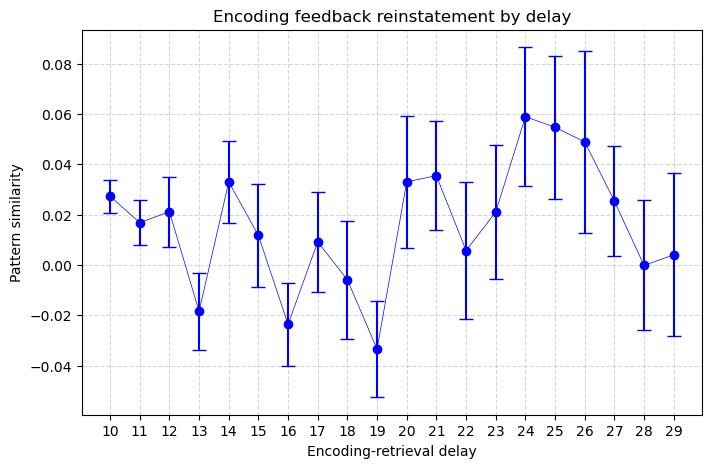

In [ ]:
# are encoding trials more similar to retrieval trials the closer you are
# if so, is this above a delay-matched control?
from collections import defaultdict

delay_to_ps = defaultdict(list)
for sub_num in range(1,32):
    sub_delay_to_ps = defaultdict(list)
    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1 and row.encTrialNum in beh_data.Trial.to_numpy():
            idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
            ps = corr_matrix[i, idx_of_enc_trial]
            delay = str(row.Delay.astype(int))
            sub_delay_to_ps[delay].append(ps)
        
    for key,value in sub_delay_to_ps.items():
        delay_to_ps[key].append(np.mean(value))

nh.plot_ers_delay(dict(delay_to_ps),title='Encoding feedback reinstatement by delay', xlabel='Encoding-retrieval delay')

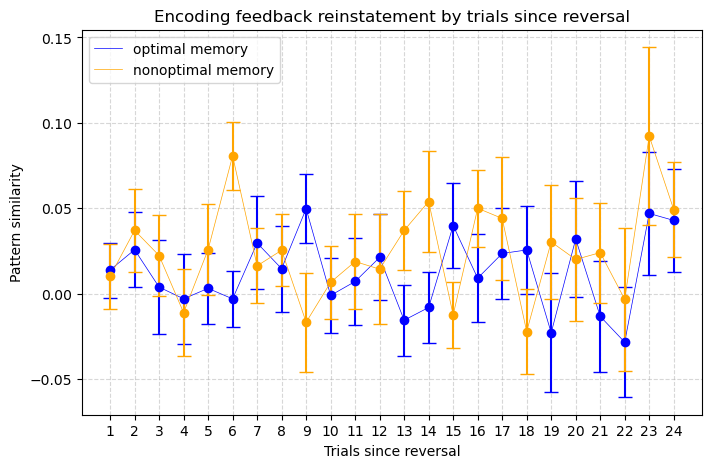

In [ ]:
# do you get less ERS the further you go into reversal period?
# are encoding trials more similar to retrieval trials the closer you are
# if so, is this above a delay-matched control?

revt_to_ps_opt = defaultdict(list)
revt_to_ps_nonopt = defaultdict(list)

for sub_num in range(1,32):
    sub_revt_to_ps_opt = defaultdict(list)
    sub_revt_to_ps_nonopt = defaultdict(list)
    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1 and row.encTrialNum in beh_data.Trial.to_numpy():
            idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
            ps = corr_matrix[i, idx_of_enc_trial]
            revt = row.RevT.astype(int)

            if row.OptObj ==1:
                sub_revt_to_ps_opt[revt].append(ps)
            else:
                sub_revt_to_ps_nonopt[revt].append(ps)
        
    for key,value in sub_revt_to_ps_opt.items():
        revt_to_ps_opt[key].append(np.mean(value))
    for key,value in sub_revt_to_ps_nonopt.items():
        revt_to_ps_nonopt[key].append(np.mean(value))

nh.plot_revt_ps(dict(revt_to_ps_opt),dict(revt_to_ps_nonopt),
                title='Encoding feedback reinstatement by trials since reversal', xlabel='Trials since reversal')

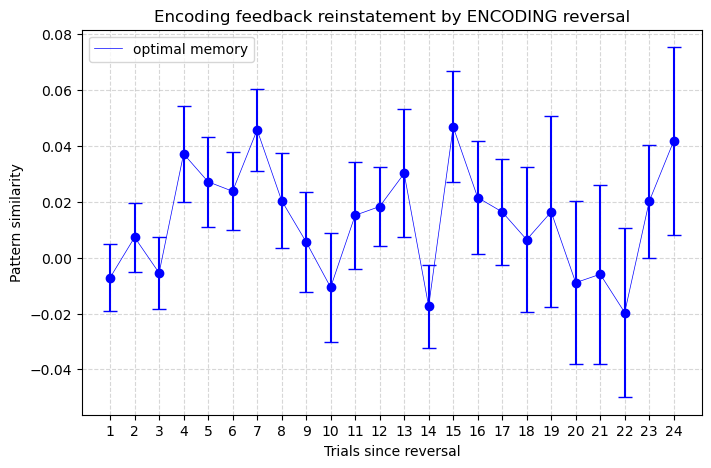

In [ ]:
# do you get less ERS the further you go into ENCODING reversal period?
# are encoding trials more similar to retrieval trials the closer you are
# if so, is this above a delay-matched control?

revt_to_ps = defaultdict(list)

for sub_num in range(1,32):
    sub_revt_to_ps = defaultdict(list)
    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1 and row.encTrialNum in beh_data.Trial.to_numpy():
            idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
            ps = corr_matrix[i, idx_of_enc_trial]
            revt = beh_data.RevT.iloc[idx_of_enc_trial].astype(int)

            sub_revt_to_ps[revt].append(ps)
        
    for key,value in sub_revt_to_ps.items():
        revt_to_ps[key].append(np.mean(value))

nh.plot_revt_ps(dict(revt_to_ps),
                title='Encoding feedback reinstatement by ENCODING reversal', xlabel='Trials since reversal')

### Similarity from one choice trial to it's own feedback trial -- predict subsequent retrieval?

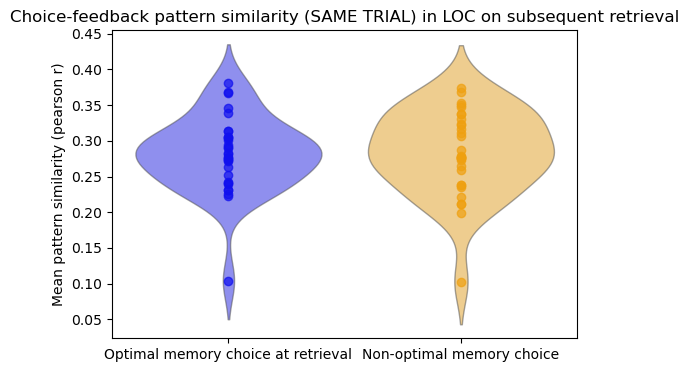

TtestResult(statistic=-0.31653249261593946, pvalue=0.7537904619835252, df=30)

In [ ]:
ps_opt = []
ps_nonopt = []

for sub_num in range(1,32):
    sub_ps_opt = []
    sub_ps_nonopt = []

    beh_data = nh.get_beh_data(sub_num)

    # get correlation of each choice phase with it's own feedback phase
    stacked_choice_fb = np.vstack([all_patterns[sub_num]['fb'], all_patterns[sub_num]['choice']])
    stacked_corr_matrix = np.corrcoef(stacked_choice_fb)
    n_trials = all_patterns[sub_num]['fb'].shape[0]
    choice_fb_corrs = stacked_corr_matrix[range(n_trials), range(n_trials, 2*n_trials)]

    for i,row in beh_data.iterrows():
        if row.OldT == 1: # and row.ObjDeckMatch==1
            # get encoding trial
            enc_index = beh_data.index[beh_data.Trial == row.encTrialNum]

            if row.OptObj==1:
                sub_ps_opt.append(choice_fb_corrs[i])
            else:
                sub_ps_nonopt.append(choice_fb_corrs[i])

    # subject means
    ps_opt.append(np.mean(sub_ps_opt))
    ps_nonopt.append(np.mean(sub_ps_nonopt))

nh.simple_violin(ps_opt, ps_nonopt,
              title = 'Choice-feedback pattern similarity (SAME TRIAL) in LOC on subsequent retrieval', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Optimal memory choice at retrieval', x2_label = 'Non-optimal memory choice')

ttest_rel(ps_opt, ps_nonopt)

### Other

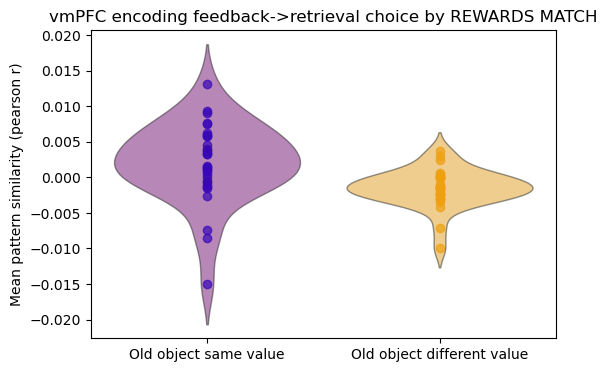

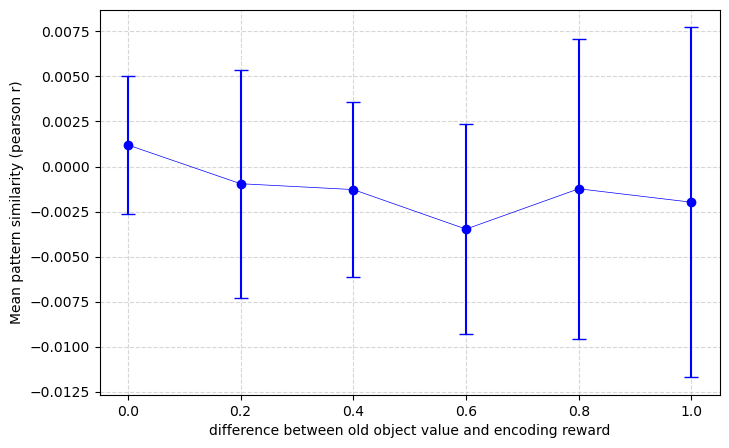

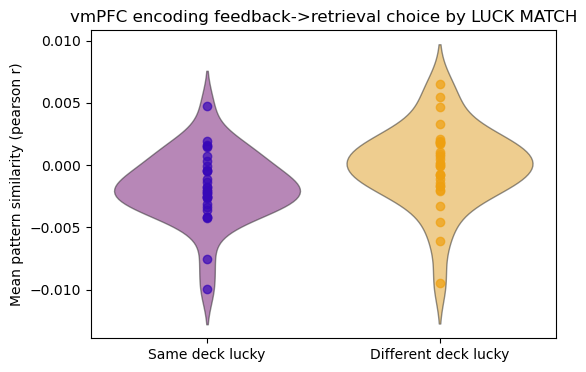

In [197]:
# by value match and luck match

# retrieval choice pattern to ALL encoding fb patterns, separate by 
#   1. was the current lucky deck, lucky then
#   2. same vs different reward outcome (and maybe reward difference)

luck_match, luck_mismatch = [],[]
reward_match, reward_mismatch = [],[]
reward_differences = [[],[],[],[],[],[]]

for sub_num in range(1,32):
    sub_luck_match, sub_luck_mismatch = [],[]
    sub_reward_match, sub_reward_mismatch = [],[]
    sub_reward_differences = [[],[],[],[],[],[]]

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub_num, 'fb_to_choice')

    for (ret_idx,enc_idx) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[ret_idx] == 1 and beh_data.encT.iloc[enc_idx] == 1:
            # retrieval choice and encoding feedback

            if beh_data.LuckyDeck.iloc[ret_idx] == beh_data.LuckyDeck.iloc[enc_idx]:
                sub_luck_match.append(corr_matrix[ret_idx,enc_idx])
            else:
                sub_luck_mismatch.append(corr_matrix[ret_idx,enc_idx])

            if beh_data.ObjPP.iloc[ret_idx] == beh_data.Outcome.iloc[enc_idx]:
                sub_reward_match.append(corr_matrix[ret_idx,enc_idx])
            else:
                sub_reward_mismatch.append(corr_matrix[ret_idx,enc_idx])

            reward_diff = abs(beh_data.ObjPP.iloc[ret_idx] - beh_data.Outcome.iloc[enc_idx])
            idx = int(reward_diff*5 )
            sub_reward_differences[idx].append(corr_matrix[ret_idx,enc_idx])

    luck_match.append(np.mean(sub_luck_match))
    luck_mismatch.append(np.mean(sub_luck_mismatch))
    reward_match.append(np.mean(sub_reward_match))
    reward_mismatch.append(np.mean(sub_reward_mismatch))
    for i in range(len(reward_differences)):
        reward_differences[i].append(np.mean(sub_reward_differences[i]))


nh.simple_violin(reward_match, reward_mismatch,
              title = 'vmPFC encoding feedback->retrieval choice by REWARDS MATCH', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Old object same value', x2_label = 'Old object different value')
nh.simple_plot(reward_differences, x = [0,0.2,0.4,0.6,0.8,1.0],
               xlabel='difference between old object value and encoding reward', ylabel='Mean pattern similarity (pearson r)')
nh.simple_violin(luck_match, luck_mismatch,
              title = 'vmPFC encoding feedback->retrieval choice by LUCK MATCH', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Same deck lucky', x2_label = 'Different deck lucky')


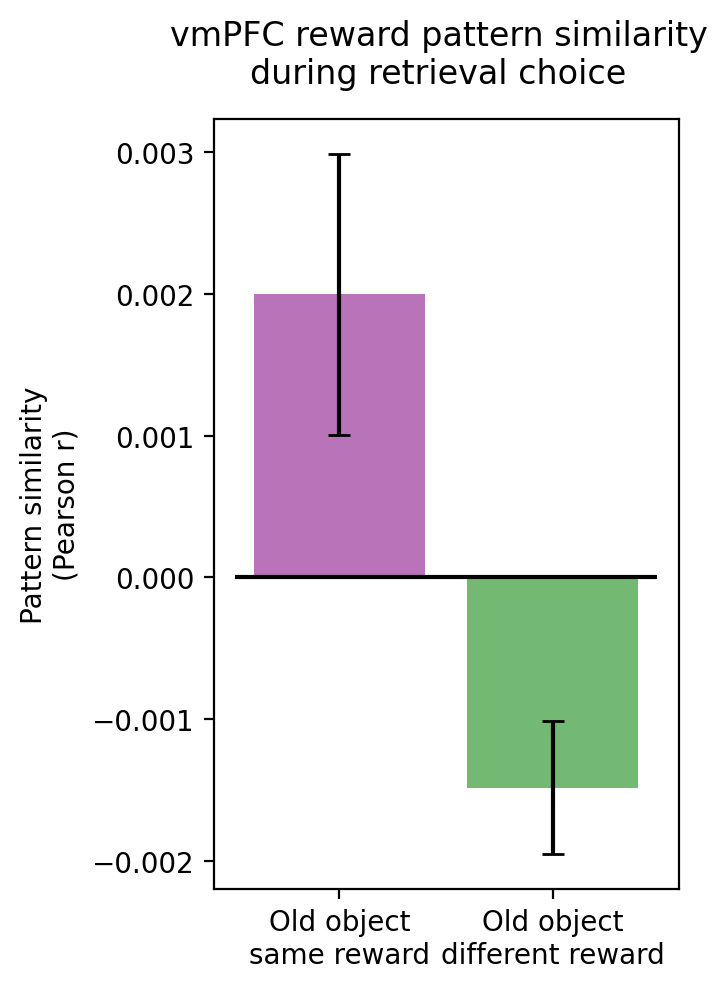

In [237]:
plt.figure(figsize=(3,5),dpi=200)
plt.bar(0,np.mean(reward_match),color='purple',alpha=0.55)
plt.errorbar(x=0,y=np.mean(reward_match),yerr=np.std(reward_match)/np.sqrt(31),color='black',capsize=4)
plt.bar(1, np.mean(reward_mismatch),color='green',alpha=0.55)
plt.errorbar(x=1,y=np.mean(reward_mismatch),yerr=np.std(reward_mismatch)/np.sqrt(31),color='black',capsize=4)
plt.hlines(y=0,xmin=plt.xlim()[0],xmax=plt.xlim()[1],color='black')
plt.xticks([0,1], labels=['Old object\nsame reward', 'Old object\ndifferent reward'])
plt.ylabel('Pattern similarity\n(Pearson r)')
plt.suptitle('vmPFC reward pattern similarity\nduring retrieval choice')
plt.show()

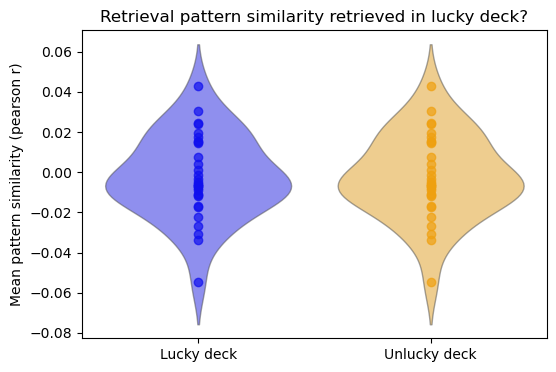

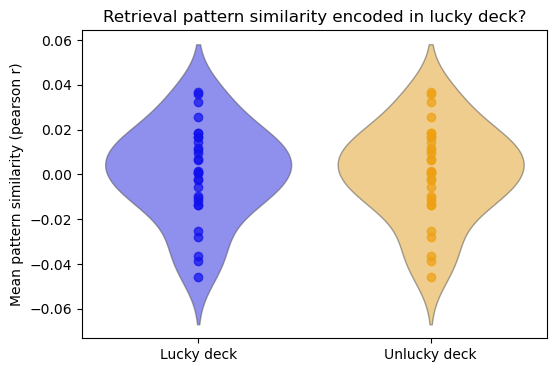

In [ ]:
# retrieved/encoded in the lucky

enc_lucky, enc_unlucky, ret_lucky, ret_unlucky = [],[],[],[]

for sub_num in range(1,32):
    sub_enc_lucky, sub_enc_unlucky, sub_ret_lucky, sub_ret_unlucky = [],[],[],[]

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')
    # oldt_idx = beh_data.index[beh_data.OldT==1].to_numpy()
    # beh_data = beh_data.iloc[oldt_idx]
    # oldt_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')[np.ix_(oldt_idx, oldt_idx)]

    for (i,j) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
            if beh_data.OldObjLuckyDeck.iloc[i]: sub_ret_lucky.append(corr_matrix[i,j])
            else: sub_ret_unlucky.append(corr_matrix[i,j])
            if beh_data.LuckyDeckC.iloc[j]: sub_enc_lucky.append(corr_matrix[i,j])
            else: sub_enc_unlucky.append(corr_matrix[i,j])
            
    enc_lucky.append(np.mean(sub_enc_lucky))
    enc_unlucky.append(np.mean(sub_enc_unlucky))
    ret_lucky.append(np.mean(sub_ret_lucky))
    ret_unlucky.append(np.mean(sub_ret_unlucky))
    

nh.simple_violin(ret_lucky, ret_lucky,
              title = 'Retrieval pattern similarity retrieved in lucky deck?', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Lucky deck', x2_label = 'Unlucky deck')

nh.simple_violin(enc_lucky, enc_lucky,
              title = 'Retrieval pattern similarity encoded in lucky deck?', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Lucky deck', x2_label = 'Unlucky deck')

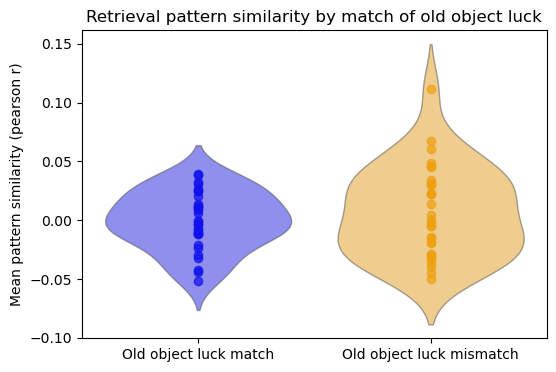

Two sample t-test result: p = 0.36375939050893225


In [ ]:
# retrieved in the same deck luck as encoding

within_luck, across_luck = [],[]

for sub_num in range(1,32):
    sub_within_luck, sub_across_luck = [],[]

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')
    # oldt_idx = beh_data.index[beh_data.OldT==1].to_numpy()
    # beh_data = beh_data.iloc[oldt_idx]
    # oldt_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')[np.ix_(oldt_idx, oldt_idx)]

    for (i,j) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
            if beh_data.OldObjLuckyDeck.iloc[i] == beh_data.LuckyDeckC.iloc[j]:
                # lucky retrieval == lucky encoding 
                sub_within_luck.append(corr_matrix[i,j])
            else:
                sub_across_luck.append(corr_matrix[i,j])

    within_luck.append(np.mean(sub_within_luck))
    across_luck.append(np.mean(sub_across_luck))

nh.simple_violin(within_luck, across_luck,
              title = 'Retrieval pattern similarity by match of old object luck', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Old object luck match', x2_label = 'Old object luck mismatch')

print('Two sample t-test result: p =', ttest_ind(within_luck, across_luck).pvalue)

# PCA

In [ ]:
from sklearn.decomposition import PCA
# color/cluster by:
# old trial or not
# lucky deck
# previous value

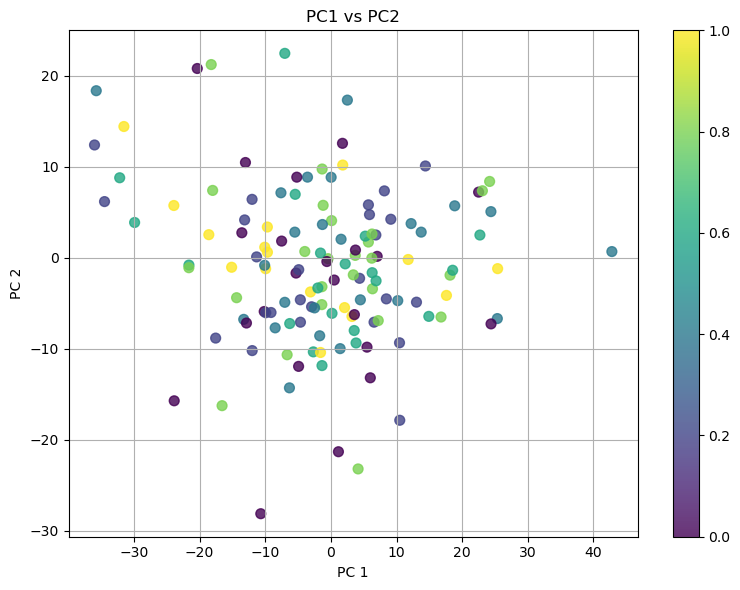

In [ ]:
sub =4

choice_pc = PCA().fit_transform(all_patterns[sub]['choice'])

def plot_pcs(X_pca, pc_x=1, pc_y=2, color_by=[], color_label=''):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, pc_x - 1], X_pca[:, pc_y - 1], c=color_by, cmap='viridis', s=50, alpha=0.8)
    plt.xlabel(f'PC {pc_x}')
    plt.ylabel(f'PC {pc_y}')
    plt.title(f'PC{pc_x} vs PC{pc_y}')
    plt.colorbar(scatter, label=color_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

beh = nh.get_beh_data(sub)['ObjPP']
plot_pcs(choice_pc, 1, 2, color_by = beh)

# Decoding

1. Contralateral/ipsilateral analyses	
	- Similarity to choice pattern during feedback
		- Higher on side with chosen object
		- Reinstating object pattern
		- Reinstating deck color??
	- Similarity to choice/FB during retrieval
		- Higher on side initially presented?
		- Relationship to retrieval choice?
2. Decode reward value
	- Higher on contralateral side?
	- Reinstated?
3. NN decoding of retrieval choice
	- What is encoding FB NN trial?
		- Is decoding higher on optimal trials?
			- Just mismatch
4. vmPFC?

## contralateral vs. ipsilateral (didn't work)

In [ ]:
all_v1_l = nh.get_all_roi_patterns('v1L')
all_v1_r = nh.get_all_roi_patterns('v1R')
# all_loc_l = nh.get_all_roi_patterns('locL')
# all_loc_r = nh.get_all_roi_patterns('locR')

def add_left_choice(beh):
    # add columns: enc_object_left, old_object_left
    beh['enc_object_left'] = [int(row.Resp==1) if row.encT==1 else np.nan for _,row in beh.iterrows()]
    # kinda weird but if Resp (1 left, 2 right) and OldObjC (0 not chosen, 1 chosen) add up to 2, then it was on left
    # (either 1 left and 1 chosen, or 2 right and 0 not chosen)
    beh['old_object_left'] = [int(row.Resp + row.OldObjC == 2) if row.OldT==1 else np.nan for _,row in beh.iterrows()]
    return beh

### actually, it doesn't work

1. We will correlate encoding patterns to retrieval patterns, separately in right and left hemispheres. The correlation should be stronger when the object is shown on the same side both times, versus when it's not. 

- I wish we could correlate encoding pattern in left hemisphere with retrieval pattern in the right hemisphere for those side-switched trials, but the patterns are not the same size. i could PCA to reduce dimensionality but idk.

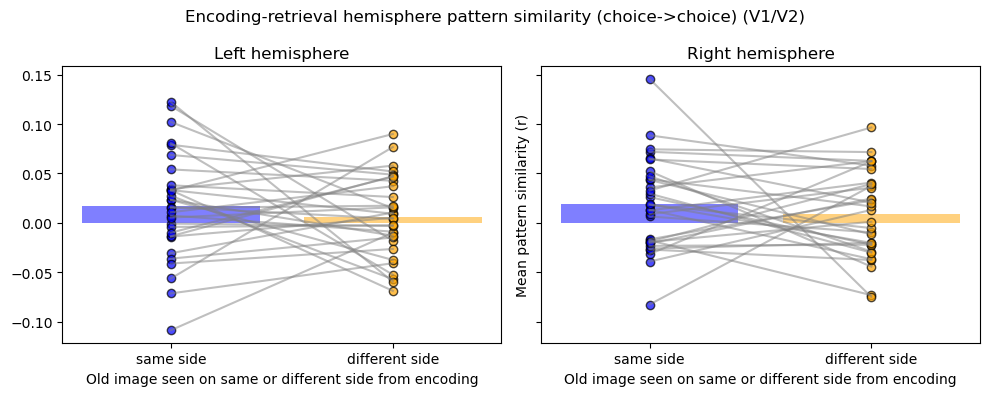

In [ ]:
def con_ips(left_patterns, right_patterns, roi):
    left_same, left_diff, right_same, right_diff = [],[],[],[]

    for sub_num in range(1,32):
        sub_left_same, sub_left_diff, sub_right_same, sub_right_diff = [],[],[],[]

        beh_data = add_left_choice(nh.get_beh_data(sub_num))
        left_corr_matrix = nh.get_corr_matrix(left_patterns, sub_num, 'choice')
        right_corr_matrix = nh.get_corr_matrix(right_patterns, sub_num, 'choice')

        for (i,j) in zip(*np.tril_indices_from(left_corr_matrix, k=-1)):
            # for each pair of trials
            if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
                # i is a retrieval trial and j is its corresponding encoding trial 
                if beh_data.old_object_left.iloc[i] == beh_data.enc_object_left.iloc[j]:
                    # the sides match
                    sub_left_same.append(left_corr_matrix[i,j])
                    sub_right_same.append(right_corr_matrix[i,j])
                else:
                    sub_left_diff.append(left_corr_matrix[i,j])
                    sub_right_diff.append(right_corr_matrix[i,j])

        left_same.append(np.mean(sub_left_same))
        left_diff.append(np.mean(sub_left_diff))
        right_same.append(np.mean(sub_right_same))
        right_diff.append(np.mean(sub_right_diff))

    nh.double_bar([left_same, left_diff, right_same, right_diff], ['same side', 'different side', 'same side', 'different side'],
                    title = f'Encoding-retrieval hemisphere pattern similarity (choice->choice) ({roi})', 
                    ax_titles = ['Left hemisphere', 'Right hemisphere'],
                    ylabel='Mean pattern similarity (r)',
                    xlabel='Old image seen on same or different side from encoding')
# print('One sample t-test result: p =', ttest_1samp(sub_avg_enc_ret_corr, 0).pvalue)

con_ips(all_v1_l, all_v1_r, roi='V1/V2')
# con_ips(all_loc_l, all_loc_r, roi='LOC')

## decoding reward from vmpfc

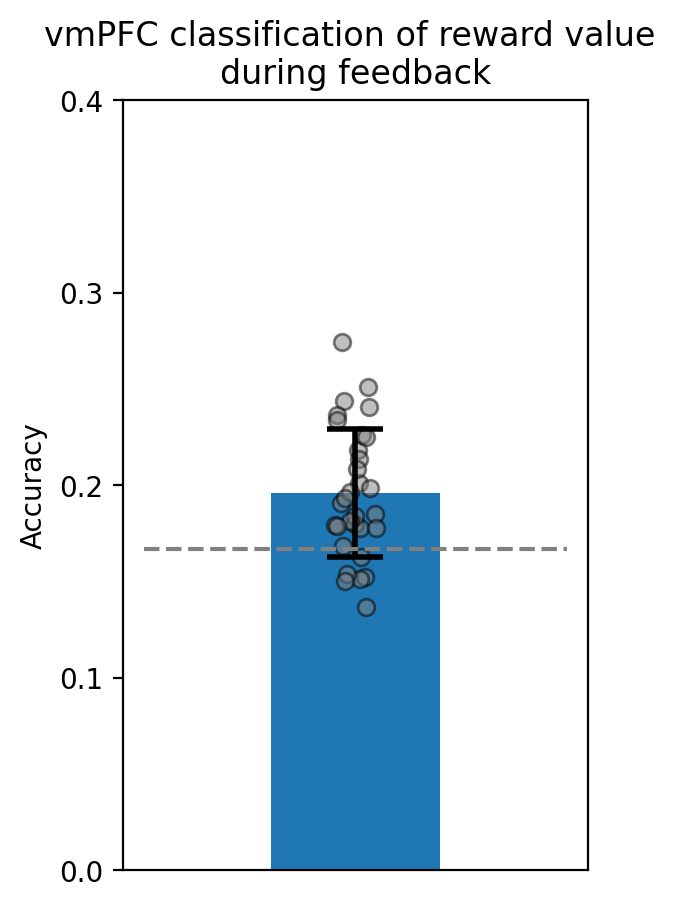

In [ ]:
# decoding reward during feedback

from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.svm import SVC

def decode_reward(X, y, method='kfold', n_splits=5, random_state=42):
    model=LogisticRegression(max_iter=500)
    model=SVC(kernel='linear')
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return scores, np.mean(scores)

acc = []
for sub in range(1,32):
    beh_data = nh.get_beh_data(sub)
    rewards = beh_data.Outcome.values.astype(str)
    patterns = vmpfc_patterns[sub]['fb']
    _, mean_acc = decode_reward(patterns, rewards, method='kfold', n_splits=10)
    acc.append(mean_acc)

plt.figure(figsize=(3,5),dpi=200)
plt.title('vmPFC classification of reward value \nduring feedback')
plt.bar(0,np.mean(acc))
plt.errorbar(x=0, y=np.mean(acc), yerr=np.std(acc), color='black', capsize=10, linewidth=2, markeredgewidth=2)
jitter = np.zeros(len(acc)) + (np.random.rand(len(acc))-0.5)/5
plt.scatter(jitter, acc, color='gray', edgecolor='black', alpha=0.5)
plt.hlines(y=1/6, xmin=-1, xmax=1, linestyle='--', color='gray')
plt.ylim(0,0.4)
plt.yticks([0,0.1,0.2,0.3,0.4])
plt.ylabel('Accuracy')
plt.xticks([])
plt.show()

ttest_1samp(acc, 1/6)

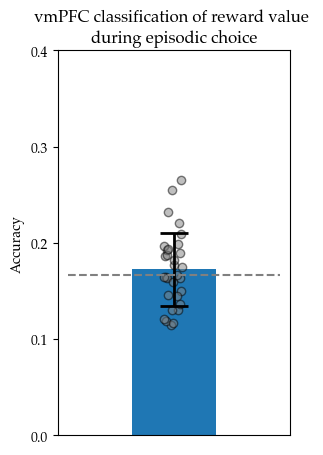

TtestResult(statistic=0.8655653607314157, pvalue=0.39359799576232735, df=30)

In [12]:
# decoding subsequent choice

from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.svm import SVC

def decode_reward(X, y, method='kfold', n_splits=5, random_state=42):
    model=LogisticRegression(max_iter=500)
    model=SVC(kernel='linear')
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return scores, np.mean(scores)

acc = []
for sub in range(1,32):
    beh_data = nh.get_beh_data(sub)
    rewards = beh_data.ObjPP.values.astype(str)[beh_data.OldT==1]
    patterns = vmpfc_patterns[sub]['choice'][beh_data.OldT==1]
    _, mean_acc = decode_reward(patterns, rewards, method='kfold', n_splits=10)
    acc.append(mean_acc)

plt.figure(figsize=(3,5),dpi=100)
plt.title('vmPFC classification of reward value \nduring episodic choice')
plt.bar(0,np.mean(acc))
plt.errorbar(x=0, y=np.mean(acc), yerr=np.std(acc), color='black', capsize=10, linewidth=2, markeredgewidth=2)
jitter = np.zeros(len(acc)) + (np.random.rand(len(acc))-0.5)/5
plt.scatter(jitter, acc, color='gray', edgecolor='black', alpha=0.5)
plt.hlines(y=1/6, xmin=-1, xmax=1, linestyle='--', color='gray')
plt.ylim(0,0.4)
plt.yticks([0,0.1,0.2,0.3,0.4])
plt.ylabel('Accuracy')
plt.xticks([])
plt.show()

ttest_1samp(acc, 1/6)

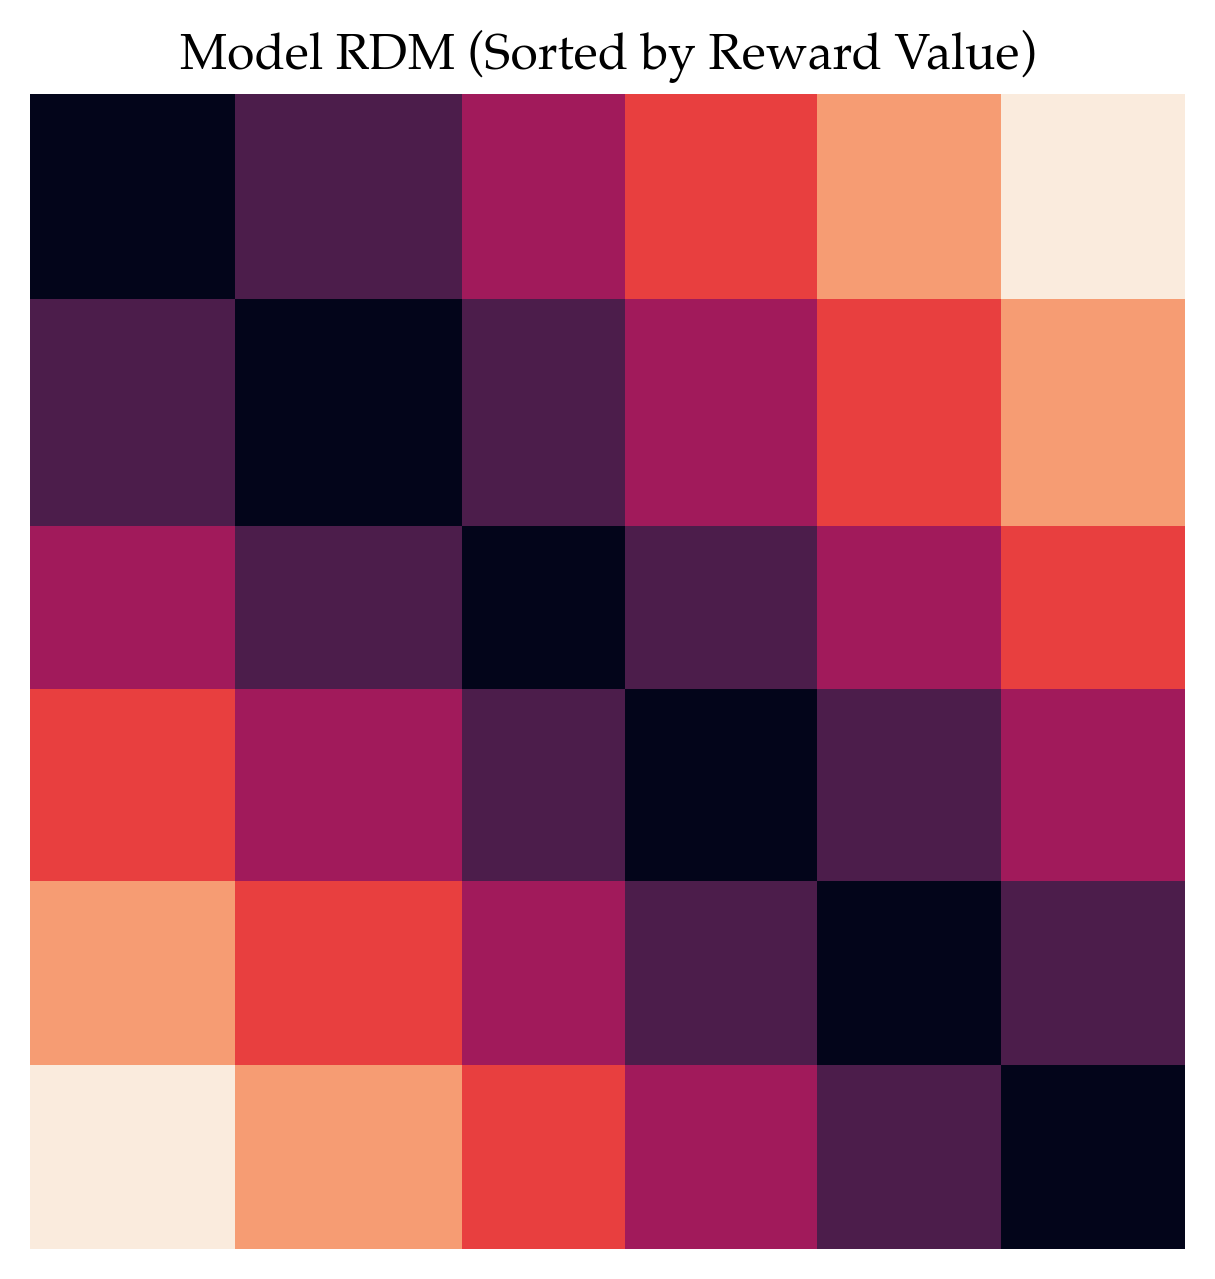

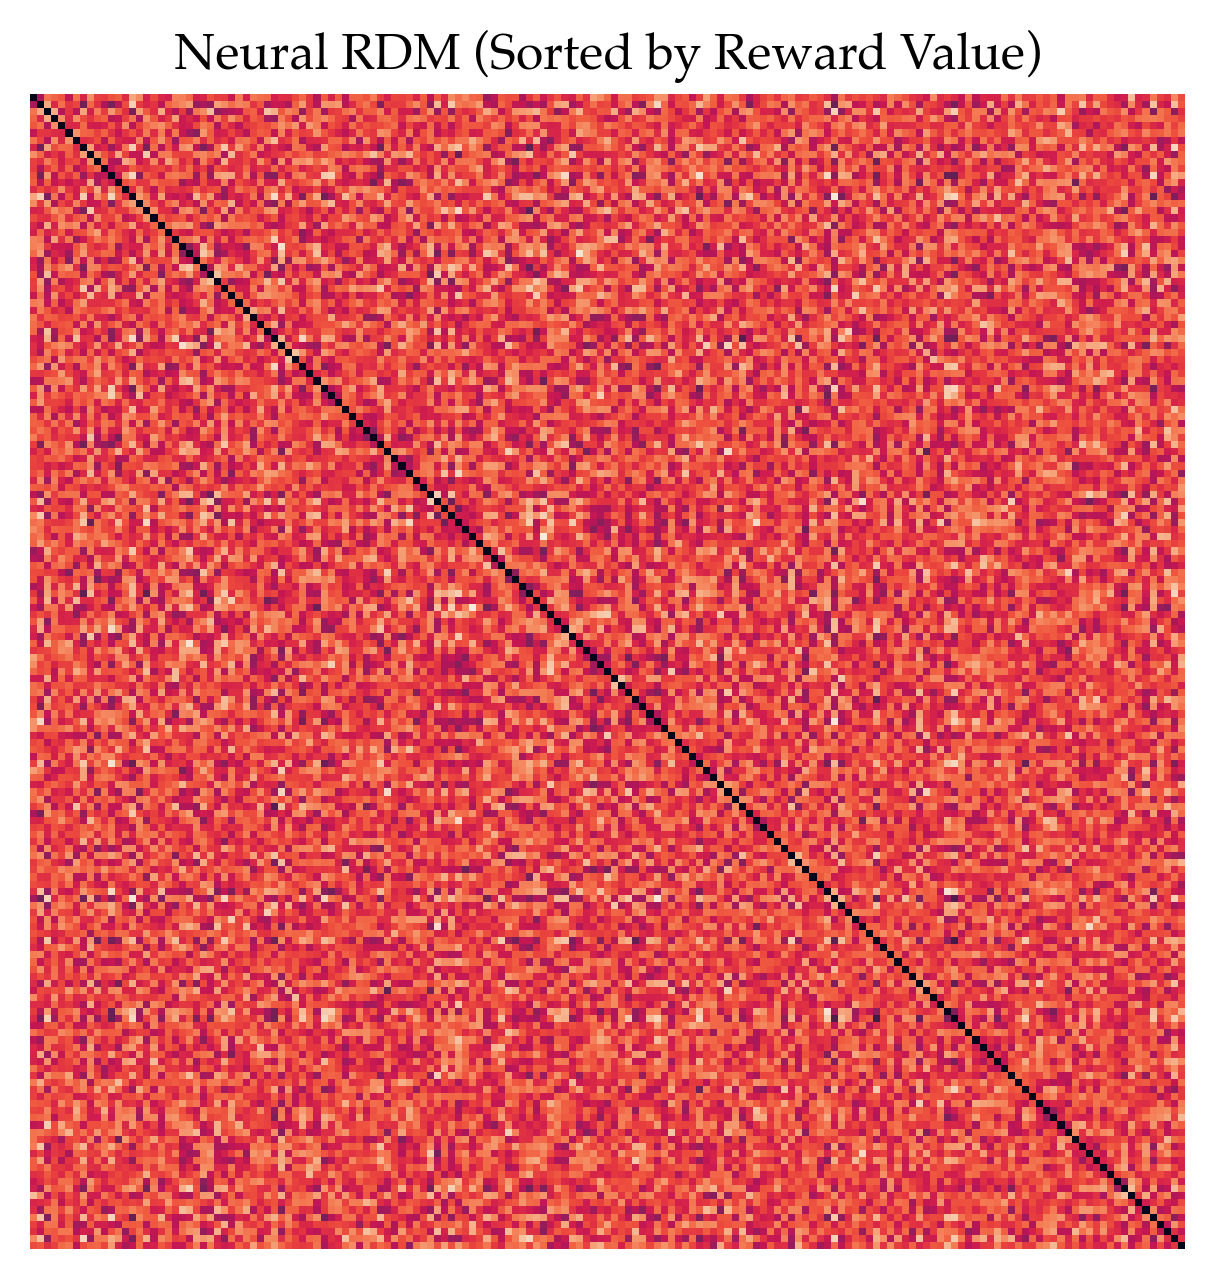

In [7]:
beh_data = nh.get_beh_data(1)
newtrials = beh_data.OldT == 0
y = beh_data[newtrials].Outcome.values
X = vmpfc_patterns[1]['fb'][newtrials]

sort_idx = np.argsort(y)
y_sorted = y[sort_idx]
X_sorted = X[sort_idx]

model_rdm = np.abs(y_sorted[:, None] - y_sorted[None, :])
neural_rdm = 1 - np.corrcoef(X_sorted)

plt.figure(figsize=(6, 5),dpi=300)
sns.heatmap(model_rdm, square=True, cbar=False)
plt.xticks([])
plt.yticks([])
plt.title("Model RDM (Sorted by Reward Value)")
plt.show()
plt.figure(figsize=(6, 5),dpi=300)
sns.heatmap(neural_rdm, square=True, cbar=False)
plt.xticks([])
plt.yticks([])
plt.title("Neural RDM (Sorted by Reward Value)")
plt.show()


100%|██████████| 31/31 [01:20<00:00,  2.58s/it]


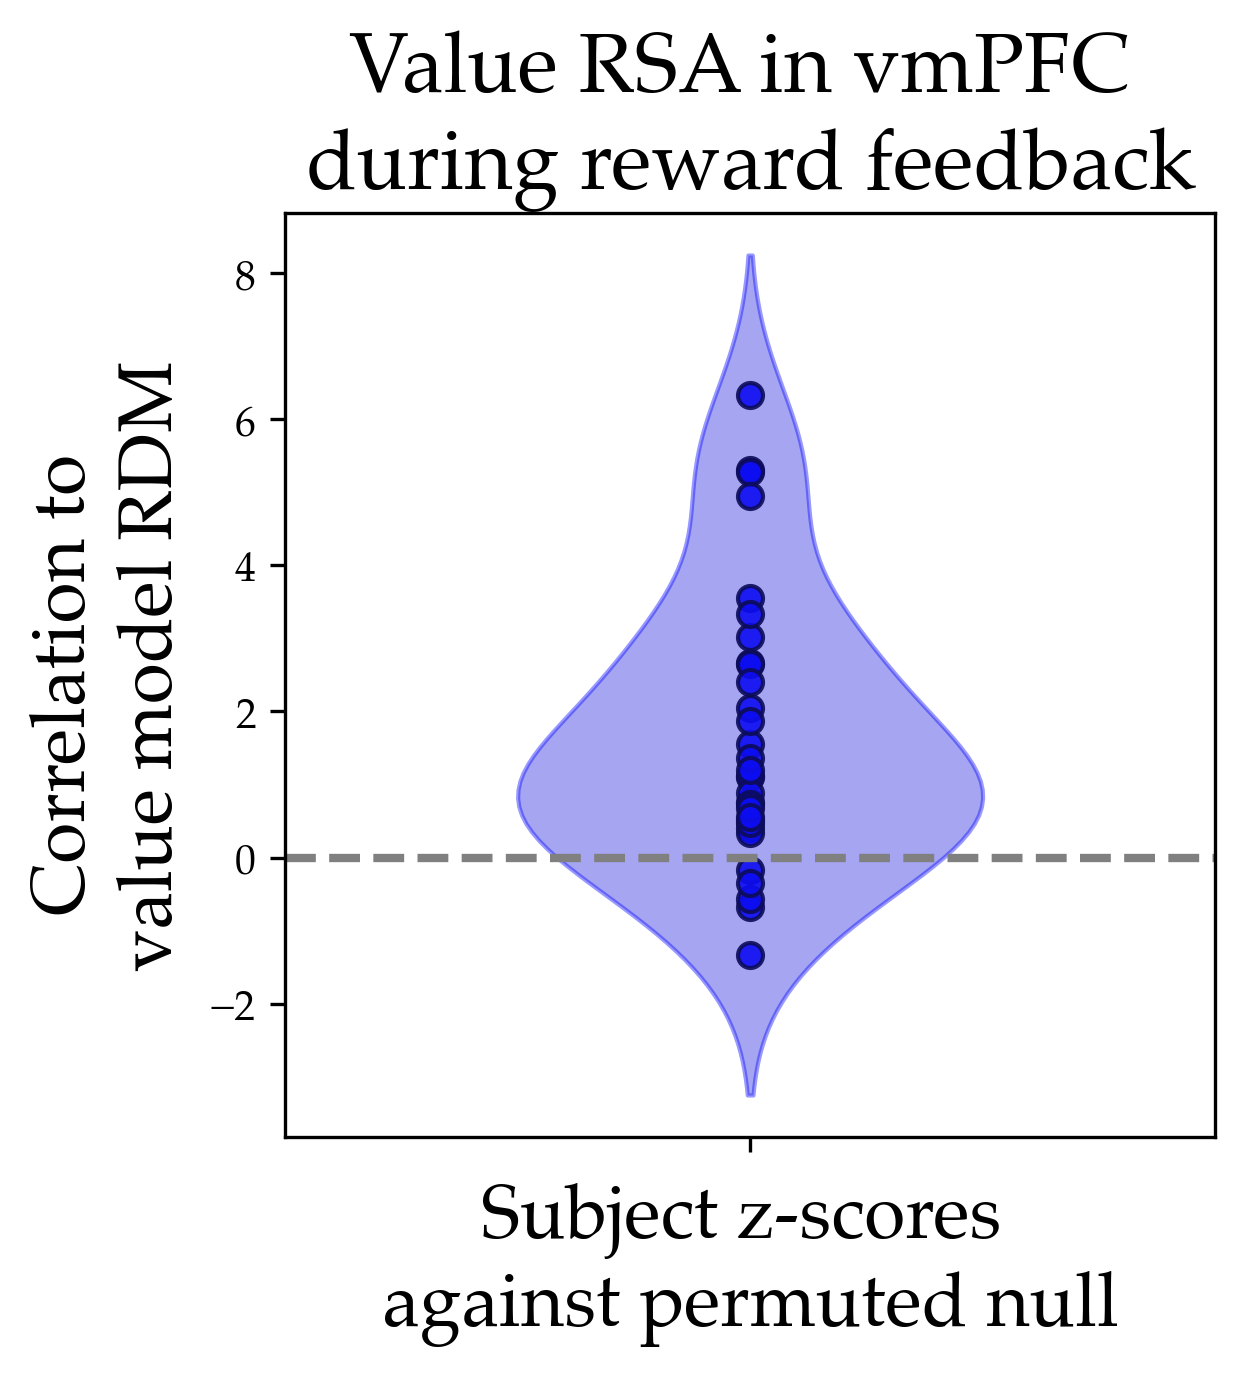

TtestResult(statistic=4.9133950287353025, pvalue=2.9748284201381403e-05, df=30)

In [8]:
# RSA of reward during feedback
from scipy.stats import spearmanr
from tqdm import tqdm

def rsa_value_models(n_perm=1000):
    z_scores = []

    for subj in tqdm(range(1,32)):

        beh_data = nh.get_beh_data(subj)
        newtrials = beh_data.OldT==0
        y = beh_data[newtrials].Outcome.values # scalar reward values
        X = vmpfc_patterns[subj]['fb'][newtrials]

        neural_rdm = 1 - np.corrcoef(X)
        # model_rdm = (y[:, None] != y[None, :]).astype(float)
        model_rdm = np.abs(y[:, None] - y[None, :]) # model is scalar difference in reward

        # Vectorize upper triangle
        triu_idx = np.triu_indices_from(neural_rdm, k=1)
        neural_vec = neural_rdm[triu_idx]
        model_vec = model_rdm[triu_idx]

        # Observed correlations
        rho_obs = spearmanr(neural_vec, model_vec).correlation

        # Null distributions
        rhos_null = []
        for _ in range(n_perm):
            y_shuff = np.random.permutation(y)
            model_rdm_shuff = np.abs(y_shuff[:, None] - y_shuff[None, :])
            rhos_null.append(spearmanr(neural_vec, model_rdm_shuff[triu_idx]).correlation)

        # Compute z-scores
        z = (rho_obs - np.mean(rhos_null)) / np.std(rhos_null)
        z_scores.append(z)

    return np.array(z_scores)


zscores = rsa_value_models()
nh.simple_violin(zscores, figsize=(4,4), dpi=300,
                 xlim=(-0.8,0.8),
                 xlabel='Subject z-scores \nagainst permuted null',#Subject z-scores against permuted nullCorrelation of vmPFC patterns to reward RDM \n(subject z-scores against permuted null)', 
                 ylabel='Correlation to \n value model RDM',
                 title='Value RSA in vmPFC \nduring reward feedback',
                 chancelabel='mean of subject null')

ttest_1samp(zscores,0)

100%|██████████| 31/31 [00:47<00:00,  1.52s/it]


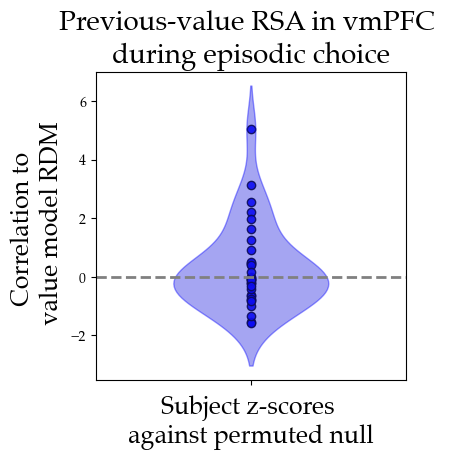

TtestResult(statistic=1.2618299865419622, pvalue=0.2167327381461528, df=30)

In [10]:
# RSA of reward during SUBSEQUENT CHOICE
from scipy.stats import spearmanr
from tqdm import tqdm

def rsa_value_models(n_perm=1000):
    z_scores = []

    for subj in tqdm(range(1,32)):

        beh_data = nh.get_beh_data(subj)
        oldtrials = (beh_data.OldT==1)
        y = beh_data[oldtrials].ObjPP.values # scalar PREVIOUS reward values
        X = vmpfc_patterns[subj]['choice'][oldtrials]

        neural_rdm = 1 - np.corrcoef(X)
        model_rdm = np.abs(y[:, None] - y[None, :]) # model is scalar difference in reward

        # Vectorize upper triangle
        triu_idx = np.triu_indices_from(neural_rdm, k=1)
        neural_vec = neural_rdm[triu_idx]
        model_vec = model_rdm[triu_idx]

        # Observed correlations
        rho_obs = spearmanr(neural_vec, model_vec).correlation

        # Null distributions
        rhos_null = []
        for _ in range(n_perm):
            y_shuff = np.random.permutation(y)
            model_rdm_shuff = np.abs(y_shuff[:, None] - y_shuff[None, :])
            rhos_null.append(spearmanr(neural_vec, model_rdm_shuff[triu_idx]).correlation)

        # Compute z-scores
        z = (rho_obs - np.mean(rhos_null)) / np.std(rhos_null)
        z_scores.append(z)

    return np.array(z_scores)

zscores = rsa_value_models()
nh.simple_violin(zscores, figsize=(4,4), dpi=100,
                 xlim=(-0.8,0.8),
                 xlabel='Subject z-scores \nagainst permuted null',#Subject z-scores against permuted nullCorrelation of vmPFC patterns to reward RDM \n(subject z-scores against permuted null)', 
                 ylabel='Correlation to \n value model RDM',
                 title='Previous-value RSA in vmPFC \nduring episodic choice',
                 chancelabel='mean of subject null')

ttest_1samp(zscores,0)

In [ ]:
# RSA for episodic value patterns (encoding feedback to retrieval choice)
from scipy.stats import spearmanr
def encoding_retrieval_rsa(n_perm=1000):
    z_scores = []

    for subj in tqdm(range(1, 32)):
        encoding_indices, retrieval_indices, values = nh.get_encoding_retrieval_indices(subj, return_values=True)
        corr_matrix = nh.get_corr_matrix(vmpfc_patterns, subj, 'fb_to_choice') # corr_matrix[i, j] = similarity between retrieval i and encoding j


        corr_matrix = corr_matrix[retrieval_indices, encoding_indices]
        actual_correlations = corr_matrix[retrieval_indices,encoding_indices]


        # Construct model RSM: 1 for encoding-retrieval pair, 0 otherwise
        model_rsm = np.zeros_like(corr_matrix)
        model_rsm[retrieval_indices, encoding_indices] = 1

        # Vectorize lower triangle of both matrices (excluding diagonal)
        tril_mask = np.tril(np.ones_like(corr_matrix), k=-1).astype(bool)
        corr_vec = corr_matrix[tril_mask]
        model_vec = model_rsm[tril_mask]

        # Spearman correlation
        rho_obs, _ = spearmanr(corr_vec, model_vec)

        # Permutation null
        rhos_perm = []
        for _ in range(n_perm):
            # Shuffle within value groups
            permuted_indices = np.arange(len(values))
            for val in np.unique(values):
                same_val_idx = np.where(values == val)[0]
                np.random.shuffle(same_val_idx)
                permuted_indices[values == val] = same_val_idx

            perm_corr_matrix = corr_matrix[permuted_indices][:, permuted_indices]
            perm_corr_vec = perm_corr_matrix[tril_mask]
            rho_perm, _ = spearmanr(perm_corr_vec, model_vec)
            rhos_perm.append(rho_perm)

        # Compute z-score
        rhos_perm = np.array(rhos_perm)
        z = (rho_obs - rhos_perm.mean()) / rhos_perm.std(ddof=1)
        z_scores.append(z)

    return np.array(z_scores)


zscores_enc_ret = encoding_retrieval_rsa()
nh.simple_violin(zscores_enc_ret, figsize=(4,4), dpi=200,
                 xlim=(-0.8,0.8),
                 xlabel='Correlation of vmPFC patterns to episodic-value RDM \n(subject z-scores against permuted null)', 
                 ylabel='Z-score of data-model RDM correlation',
                 title='Episodic reinstatement RSA in vmPFC',
                 chancelabel='mean of subject null RDM', legend=True)
ttest_1samp(zscores_enc_ret)

In [ ]:
# decode at retrieval choice (doesn't work)
def decode_reward(X, y, n_splits=10, random_state=42):
    model=LogisticRegression(max_iter=500)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return scores, np.mean(scores)

ret_acc = []
for sub in range(1,32):
    beh_data = nh.get_beh_data(sub)
    newtrials = beh_data.OldT==1
    rewards = beh_data.ObjPP[newtrials].values.astype(str)
    patterns = vmpfc_patterns[sub]['choice'][newtrials]
    _, mean_acc = decode_reward(patterns, rewards, n_splits=20)
    ret_acc.append(mean_acc)

plt.figure(figsize=(3,5),dpi=200)
plt.title('vmPFC classification of previous reward value \nduring retrieval choice')
plt.bar(0,np.mean(ret_acc))
plt.errorbar(x=0, y=np.mean(ret_acc), yerr=np.std(ret_acc), color='black', capsize=10, linewidth=2, markeredgewidth=2)
jitter = np.zeros(len(ret_acc)) + (np.random.rand(len(ret_acc))-0.5)/5
plt.scatter(jitter, ret_acc, color='gray', edgecolor='black', alpha=0.5)
plt.hlines(y=1/6, xmin=-1, xmax=1, linestyle='--', color='gray')
plt.ylim(0,0.4)
plt.yticks([0,0.1,0.2,0.3,0.4])
plt.ylabel('Accuracy')
plt.xticks([])
plt.show()

In [ ]:
# train on encoding feedback, test on retrieval choice (doesn't work)

def encoding_retrieval_decoding(train_X, train_y, test_X, test_y):
    model=LogisticRegression(max_iter=500)
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    acc = np.mean(preds == test_y)
    return acc

enc_ret_acc = []
for sub in range(1,32):
    beh_data = nh.get_beh_data(sub)
    train_mask = beh_data.OldT==0
    test_mask = (beh_data.OldT==1) # & (beh_data.Q_diff < 0)
    mean_acc = encoding_retrieval_decoding(vmpfc_patterns[sub]['fb'][train_mask], 
                                beh_data.Outcome[train_mask].values.astype(str),
                                vmpfc_patterns[sub]['choice'][test_mask], 
                                beh_data.Outcome[test_mask].values.astype(str))
    enc_ret_acc.append(mean_acc)

plt.figure(figsize=(3,5),dpi=200)
plt.title('vmPFC reward decoding \n(train encoding feedback -> test retrieval choice)')
plt.bar(0,np.mean(enc_ret_acc))
plt.errorbar(x=0, y=np.mean(enc_ret_acc), yerr=np.std(enc_ret_acc), color='black', capsize=10, linewidth=2, markeredgewidth=2)
jitter = np.zeros(len(enc_ret_acc)) + (np.random.rand(len(enc_ret_acc))-0.5)/5
plt.scatter(jitter, enc_ret_acc, color='gray', edgecolor='black', alpha=0.5)
plt.hlines(y=1/6, xmin=-1, xmax=1, linestyle='--', color='gray')
plt.ylim(0,0.4)
plt.yticks([0,0.1,0.2,0.3,0.4])
plt.ylabel('Accuracy')
plt.xticks([])
plt.show()

### other stuff

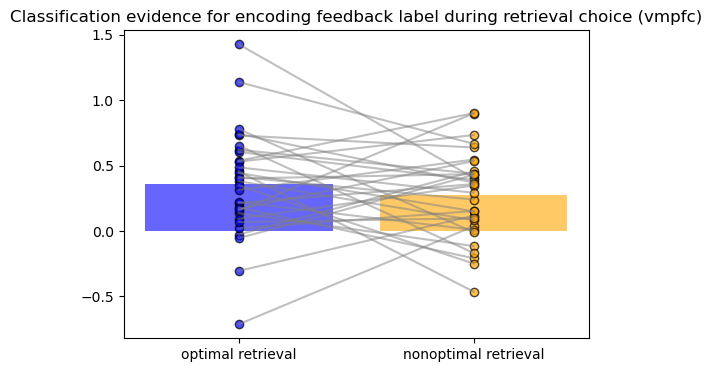

TtestResult(statistic=1.0239929849612213, pvalue=0.3140251943999816, df=30)

In [ ]:
# is classification evidence higher on trials with OptObj == 1?
avg_opt_evidence = []
avg_nonopt_evidence = []

for sub in range(1,32):
    beh = nh.get_beh_data(sub)
    oldt_and_valid_enc_mask = beh.encTrialNum.isin(beh.Trial)

    # fit classifier on all the other trials, feedback period
    fb_patterns = vmpfc_patterns[sub]['fb'][~oldt_and_valid_enc_mask]
    reward_labels = beh.Outcome.to_numpy().astype(str)[~oldt_and_valid_enc_mask]
    model = LogisticRegression(max_iter=500)
    model.fit(fb_patterns, reward_labels)

    # Get decision function on choice patterns
    choice_patterns = vmpfc_patterns[sub]['choice'][oldt_and_valid_enc_mask]
    decision_scores = model.decision_function(choice_patterns)

    # gget evidence for the 'correct' labels; i.e., the reward of the encoding trial
    enc_reward_labels = [beh.loc[beh.index[beh.Trial == row.encTrialNum][0], 'Outcome'].astype(str) for _,row in beh[oldt_and_valid_enc_mask].iterrows()]
    label_map = {label: i for i, label in enumerate(model.classes_)}
    evidence = np.array([decision_scores[i, label_map[label]] for i, label in enumerate(enc_reward_labels)])

    # Group by OptObj
    opt_mask = beh[oldt_and_valid_enc_mask].OptObj==1
    opt_evidence = evidence[opt_mask]
    nonopt_evidence = evidence[~opt_mask]

    avg_opt_evidence.append(np.mean(opt_evidence))
    avg_nonopt_evidence.append(np.mean(nonopt_evidence))


nh.simple_bar(avg_opt_evidence, avg_nonopt_evidence, x1_label = 'optimal retrieval', x2_label='nonoptimal retrieval',
              title = 'Classification evidence for encoding feedback label during retrieval choice (vmpfc)')

ttest_rel(avg_opt_evidence, avg_nonopt_evidence)

nearest neighbor decoding of encoding trial from retrieval trial data


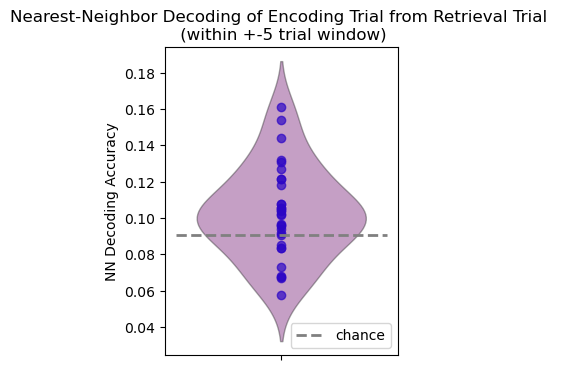

In [ ]:
sub_acc = []
for sub in range(1,32):
    beh_data = nh.get_beh_data(sub)
    corr_matrix = nh.get_corr_matrix(vmpfc_patterns, sub, 'fb_to_choice')
    encoding_indices, retrieval_indices = nh.get_encoding_retrieval_indices(sub)

    count = 0
    for enc_idx,ret_idx in zip(encoding_indices, retrieval_indices):
        corrs_to_check = corr_matrix[ret_idx, max(0,enc_idx-5):min(len(corr_matrix)-1, enc_idx+6)]
        if max(corrs_to_check) == corr_matrix[ret_idx, enc_idx]:
            count +=1

    sub_acc.append(count / len(encoding_indices))

plt.figure(figsize=(3, 4))#,dpi=200)
plt.title('Nearest-Neighbor Decoding of Encoding Trial from Retrieval Trial \n (within +-5 trial window)')
plt.scatter(np.zeros_like(sub_acc), sub_acc, color="blue", alpha=0.7)
sns.violinplot(sub_acc, color='purple', inner=None, linewidth=1, alpha = 0.4)        
plt.ylabel('NN Decoding Accuracy')
xmin,xmax = plt.xlim()
plt.hlines(y=1/11, xmin=xmin, xmax=xmax, color='gray',linewidth=2,linestyle='--', label='chance')
plt.legend(loc='lower right')
plt.show()

In [ ]:
plt.figure()
plt.title('vmPFC classification of reward value \n during feedback, new trials')
plt.bar(0,np.mean(r2))
plt.errorbar(x=0, y=np.mean(acc), yerr=np.std(acc), color='black', capsize=10, linewidth=2, markeredgewidth=2)
jitter = np.zeros(len(acc)) + (np.random.rand(len(acc))-0.5)/5
plt.scatter(jitter, acc, color='gray', edgecolor='black', alpha=0.5)
plt.hlines(y=1/6, xmin=-1, xmax=1, linestyle='--', color='gray')
plt.ylim(0,0.5)
plt.ylabel('Accuracy')
plt.xticks([])
plt.show()